## Residential energy emissions demo

This notebook gives a demonstration of how energy and emissions per capita can be calculated for the metro area of Lille.

It is a first effort and contains many necessary (at this point) assumptions, most of which can hopefully be replaced with better data or better assumptions in the future.

The following data are used:
 - [BNDB](https://www.bdnb.eu/bdnb/bdnb_presentation/) database containing energy and emission certificates from [DPE](https://www.ecologie.gouv.fr/diagnostic-performance-energetique-dpe) as well as building locations
 - [EUBUCCO](https://eubucco.com/) data of building footprints, heights, type, age
 - INSEE population and density data, calculated previously using custom spatial units designed for the urban mobility survey in Lille metro

For this demo we use BNDB and INSEE data ffor rom the French department 'Nord' (# 59), which is merged with EUBUCCO data for the metro of Lille 

The most important assumptions made for now are:
 - Estimation of number of stories based on building height with EUBUCCO data, to enable calculation of Gross Floor Area. See section 4 
 - Assume that all buildings with no type label in EUBUCCO are not residential buildings
 - Assume a constant 1.2 scaling factor between living area and gross floor area in all buildings
 - Assume that the share of building vintages for buildings with age attributes in EUBUCCO is representative of the actual vintage distribution in spatial units

Further, one possible bias inherited from the type labelling in EUBUCCO is the labelling of mixed-use multi-storey buildings as solely residential. I suspect this becuase the center of Lille, where there is a high concentration of large multi-storey buildings, has by far the highest calculated residential m2/cap (83 m2/cap, wrt average of ~50 m2/cap). I suspect that some large mixed-use buildings (which are probably majority residential) are classified as residential only, leading to an overestimation of residential floorspace and m2/cap. This is to be investigated further.

In [1]:
# load required libraries

import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import CRS
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import pickle
from shapely.validation import make_valid
from citymob import remove_holes, remove_invalid_geoms, remove_slivers, import_csv_w_wkt_to_gdf
import sys
from shapely.geometry import Point, Polygon, MultiPolygon
import math
import shapely.wkt
from shapely.wkt import loads,dumps

### 1. Load and clean DPE and georeference data from BNDB database

#### Assumptions/decisions in this section: 
 - restrict to DPE estimates using the 2021 methodology only

The [dpe_logement](https://www.bdnb.eu/schema/latest/tables/dpe_logement.html) file contains housing DPE data including energy and emission intensities for residential dwellings, and physical building characteristics 

In [2]:
dpe_log=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/dpe_logement.csv')
dpe_log_col=dpe_log.columns.to_list() # there are a lot of columns
dpe_log.head()

C:\Users\peter\AppData\Local\Temp\ipykernel_11168\2919012715.py:1: DtypeWarning: Columns (8,17,18,19,20,26,29,35,39,42,48,70,75,76,77,84,85,86,92,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  dpe_log=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/dpe_logement.csv')


,identifiant_dpe,code_departement_insee,arrete_2021,type_dpe,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,version,date_etablissement_dpe,date_reception_dpe,...,type_porte,surface_porte,u_porte,classe_inertie,deperdition_mur,deperdition_baie_vitree,deperdition_plancher_bas,deperdition_plancher_haut,deperdition_pont_thermique,deperdition_porte
0,0059L1000001@,59,0,dpe arrêté 2012 3cl immeuble,immeuble,1989-2000,1996.0,NaN,NaN,2017/05/30 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
1,0059L1000002A,59,0,dpe arrêté 2012 3cl immeuble,immeuble,1948-1974,1971.0,NaN,NaN,2017/05/31 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
2,0059L1000003,59,0,dpe arrêté 2012 3cl logement,appartement,1989-2000,1995.0,NaN,NaN,2019/07/25 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
3,0059L1000004,59,0,dpe arrêté 2012 3cl logement,appartement,1989-2000,1995.0,NaN,NaN,2019/07/25 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
4,0059L1000005D,59,0,dpe arrêté 2012 3cl logement,appartement,1989-2000,1995.0,NaN,NaN,2019/08/04 00:00:00,...,NaN,NaN,NaN,Lourde,NaN,NaN,NaN,NaN,NaN,NaN


Restrict to dwellings with DPE records using the updated 2021 methodology. These records also contain emission intensities, and dwelling living area values

In [3]:
print('total number of records', len(dpe_log))
dpe_log=dpe_log.loc[dpe_log['arrete_2021']==1,]
print('total number of records with 2021 method DPE', len(dpe_log))

total number of records 284876
total number of records with 2021 method DPE 51811


Use the `adresse` and `rel_batiment_groupe_dpe_logement` files to add geographic data to the DPE data, including point estimates of the building addresses. NB the points are not individual specific to individual buildings or dwellings, as individual addresses can relate to multiple building groups, and each building group can refer to multiple buildings/dwellings. 

This is a part of the [hierarchical](https://www.bdnb.eu/documentation/modele_donnees/) building location identification in BNDB, and the lack of specific location id for individual dwellings in the public BNDB, which we don't dwell on here.

In [4]:
# we know the crs of the csv file is 2154, as it is the same as the gpkg which can also be donwloaded from BNDB and contains mostly the same info as `adresse`
add = import_csv_w_wkt_to_gdf('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/adresse.csv',crs=2154,geometry_col='WKT',gc='code_postal') # gc means that the specified column is read as a string
add.head()

,WKT,cle_interop_adr,code_departement_insee,numero,rep,nom_voie,type_voie,code_commune_insee,code_postal,libelle_commune,source,geometry
0,POINT (761237.127001409 6993772.84289119),02-AISN-276828,59,7,NaN,des bruniers,rue,59241,NaN,Floyon,Arcep,POINT (761237.127 6993772.843)
1,POINT (737080.587487689 7028881.04234662),186855650575723,59,6,B,des dentellieres,avenue,59606,NaN,Valenciennes,Arcep,POINT (737080.587 7028881.042)
2,POINT (736851.339650684 7029549.26831763),186855700165357,59,43,B,du senateur girard,avenue,59606,NaN,Valenciennes,Arcep,POINT (736851.340 7029549.268)
3,POINT (736950.725348686 7029579.81433162),186855740577684,59,19,NaN,du marechal foch,avenue,59606,NaN,Valenciennes,Arcep,POINT (736950.725 7029579.814)
4,POINT (737085.741848688 7029422.28830762),186856150579663,59,3,NaN,girot,cour,59606,NaN,Valenciennes,Arcep,POINT (737085.742 7029422.288)


In [5]:
# then load the file with ids containing the relationship between addresses ('cle_interop_adr'), building groups ('batiment_groupe_id'), and dpes ('identifiant_dpe')
rel_bldgroup_dpe_log=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/rel_batiment_groupe_dpe_logement.csv')
rel_bldgroup_dpe_log.head()

,batiment_groupe_id,identifiant_dpe,code_departement_insee,cle_interop_adr,adresse_brut,adresse_geocodee,fiabilite_geocodage
0,59512000IN0090_b45ee30e81da3f7,1959V2014824D,59,59512_2540_00095,95 Rue D Hem 59100 Roubaix,95 Rue d’Hem 59100 Roubaix,très fiable
1,59512000IO0196_67d7fd8ce86b410,1459V2008109X,59,59512_2720_00009,9 Rue Ingres 59100 Roubaix,9 Rue Ingres 59100 Roubaix,très fiable
2,59512000IK0019_5206a20845e2bc4,1659L1003092T,59,59512_1300_00036,36 Rue Coligny 59100 Roubaix,36 Rue Coligny 59100 Roubaix,très fiable
3,59512000IK0172_1be81f80ce0da53,1559V2010882@,59,59512_1300_00009,9 Rue Coligny 59100 Roubaix,9 Rue Coligny 59100 Roubaix,très fiable
4,59512000IK0153_cfaf8654038c76e,1659V1003062R,59,59512_4250_00022,22 Rue Pascal 59100 Roubaix,22 Rue Pascal 59100 Roubaix,très fiable


In [6]:
# create a gdf combining relevant columns from the address file and the relations file
geo=add.loc[:,['cle_interop_adr','code_commune_insee','libelle_commune','geometry','numero','nom_voie','code_postal']].merge(rel_bldgroup_dpe_log.loc[:,['cle_interop_adr','batiment_groupe_id','identifiant_dpe','adresse_geocodee']])
geo.head()

,cle_interop_adr,code_commune_insee,libelle_commune,geometry,numero,nom_voie,code_postal,batiment_groupe_id,identifiant_dpe,adresse_geocodee
0,59001_0060_00015,59001,Abancourt,POINT (715336.028 7014730.213),15,du couvent,59268,59001000ZL0114_2e9776063773512,2159E0128380Z,15 Rue Du Couvent 59268 Abancourt
1,59001_0100_00002,59001,Abancourt,POINT (715468.712 7015138.178),2,des fresnois,59268,590010000U1261_f0446f7084996ac,1659V2003702T,2 Rue des Fresnois 59268 Abancourt
2,59001_0100_00010,59001,Abancourt,POINT (715531.767 7015171.651),10,des fresnois,59268,uf590010396118_11a5ab3d1aaf7e1,1959V2007645G,10 Rue des Fresnois 59268 Abancourt
3,59001_0100_00020,59001,Abancourt,POINT (715392.284 7015293.327),20,des fresnois,59268,590010000U1578_762209dcad042a4,1459V2006717A,20 Rue des Fresnois 59268 Abancourt
4,59001_0100_00024,59001,Abancourt,POINT (715350.175 7015332.970),24,des fresnois,59268,uf590010000068_2cab49d0f61e5be,2159E0290655I,24 Rue Des Fresnois 59268 Abancourt


In [7]:
# define which dpe columns we want to keep and merge with the geo data
cols=['identifiant_dpe','arrete_2021','type_batiment_dpe','periode_construction_dpe','annee_construction_dpe','nombre_niveau_logement','nombre_niveau_immeuble', 'surface_habitable_immeuble',
                       'surface_habitable_logement', 'conso_5_usages_ep_m2','conso_5_usages_ef_m2', 'emission_ges_5_usages_m2',
                       'type_installation_chauffage','type_energie_chauffage','type_generateur_chauffage','type_generateur_chauffage_anciennete','type_installation_ecs','type_energie_ecs','type_generateur_ecs','type_generateur_ecs_anciennete',
                       'type_production_energie_renouvelable','type_vitrage','type_materiaux_menuiserie','type_isolation_mur_exterieur','type_isolation_plancher_bas','type_plancher_bas_deperditif','type_isolation_plancher_haut','type_plancher_haut_deperditif']
dpe_gdf=geo.merge(dpe_log.loc[:,cols])
# this gdf is slightly larger than the dpe_log gdf because there are some 'identifiant_dpe' ids which refer to multiple addresses
dpe_gdf.head()

,cle_interop_adr,code_commune_insee,libelle_commune,geometry,numero,nom_voie,code_postal,batiment_groupe_id,identifiant_dpe,adresse_geocodee,...,type_generateur_ecs,type_generateur_ecs_anciennete,type_production_energie_renouvelable,type_vitrage,type_materiaux_menuiserie,type_isolation_mur_exterieur,type_isolation_plancher_bas,type_plancher_bas_deperditif,type_isolation_plancher_haut,type_plancher_haut_deperditif
0,59001_0060_00015,59001,Abancourt,POINT (715336.028 7014730.213),15,du couvent,59268,59001000ZL0114_2e9776063773512,2159E0128380Z,15 Rue Du Couvent 59268 Abancourt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59001_0100_00024,59001,Abancourt,POINT (715350.175 7015332.970),24,des fresnois,59268,uf590010000068_2cab49d0f61e5be,2159E0290655I,24 Rue Des Fresnois 59268 Abancourt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59001_0174_00001,59001,Abancourt,POINT (714912.768 7014753.244),1,du petit bois,59268,59001000ZL0147_36b68127fe49cf7,2259E1509156U,1 Rue Du Petit Bois 59268 Abancourt,...,ecs thermodynamique electrique(pac ou ballon),neuf,NaN,double vitrage,métal avec rupture de pont thermique,ITI,ITE,dalle béton,ITI,plafond bois sous solives bois
3,59001_0240_00038,59001,Abancourt,POINT (714995.297 7015391.041),38,grand rue,59268,uf590010290913_f0c288a73424092,2259E1840909N,38 Grand Rue 59268 Abancourt,...,NaN,NaN,NaN,double vitrage,bois,ITI,ITI,dalle béton,ITI,plafond bois sous solives bois
4,59001_0260_00009,59001,Abancourt,POINT (715117.524 7015147.249),9,verte,59268,uf590010372730_ad0c213a7dfb0f7,2259E1165887D,9 Rue Verte 59268 Abancourt,...,ecs thermodynamique electrique(pac ou ballon),neuf,NaN,double vitrage,pvc,ITI,non isole,dalle béton,ITI,inconnu


In [8]:
# 'identifiant_dpe' ids which refer to multiple addresses
dpe_gdf['identifiant_dpe'].value_counts().head()

2159E0304383I    87
2259E1285018C    42
2259E1268070G    42
2259E1266556A    42
2259E1268049L    42
Name: identifiant_dpe, dtype: int64

Briefly show how buildings in this sample vary in energy/emission intensity by building type and age

In [9]:
# houses are most inefficient compared to general buildings and apartment buildings, but not a big diff
dpe_gdf.groupby('type_batiment_dpe')['conso_5_usages_ef_m2'].mean()

type_batiment_dpe
appartement    168.285729
immeuble       187.807199
maison         197.212200
Name: conso_5_usages_ef_m2, dtype: float64

In [10]:
# as expected, final energy is lower in newer buildings, and vice versa
dpe_gdf.groupby('periode_construction_dpe')['conso_5_usages_ef_m2'].mean()

periode_construction_dpe
1948-1974     227.814422
1975-1977     215.148335
1978-1982     171.564648
1983-1988     151.790886
1989-2000     129.365072
2001-2005     118.846214
2006-2012     116.147301
2013-2021      78.323022
après 2021     68.563914
avant 1948    195.727311
Name: conso_5_usages_ef_m2, dtype: float64

In [11]:
# emissions also lower in newer buildings. One exception (also applied to energy) is that the oldest age group <1948 is not the most energy/emission intensive. 
# Buildings building between 1948-1977 are the working performing in terms of energy and emissions
dpe_gdf.groupby('periode_construction_dpe')['emission_ges_5_usages_m2'].mean()

periode_construction_dpe
1948-1974     45.118825
1975-1977     42.894110
1978-1982     31.829800
1983-1988     25.324540
1989-2000     19.678905
2001-2005     18.828863
2006-2012     18.887318
2013-2021     13.033626
après 2021    13.780008
avant 1948    33.838785
Name: emission_ges_5_usages_m2, dtype: float64

### 2. Restrict to the relevant city boundary and group by spatial units (postcode/other)

Now we load in the spatial boundary for the Lille metro region, and then the shapefiles of the administrative units

<AxesSubplot:>

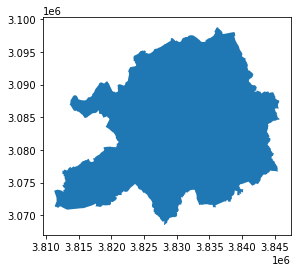

In [12]:
bound=import_csv_w_wkt_to_gdf('../../city_mobility/outputs/city_boundaries/Lille.csv',crs=3035,geometry_col='geometry')
bound.plot()

In [13]:
dpe_gdf.to_crs(3035,inplace=True)
# restrict dpe records to those within the city boundary
dpe_city=gpd.sjoin(dpe_gdf,bound.drop(columns='crs'))
dpe_city.head()

,cle_interop_adr,code_commune_insee,libelle_commune,geometry,numero,nom_voie,code_postal,batiment_groupe_id,identifiant_dpe,adresse_geocodee,...,type_generateur_ecs_anciennete,type_production_energie_renouvelable,type_vitrage,type_materiaux_menuiserie,type_isolation_mur_exterieur,type_isolation_plancher_bas,type_plancher_bas_deperditif,type_isolation_plancher_haut,type_plancher_haut_deperditif,index_right
459,59009_0011_00008,59009,Villeneuve-d'Ascq,POINT (3837013.352 3083313.020),8,de l'abbe bonpain,59650,59009000LI0415_4ce65969680ea17,2259E0681836U,8 Rue De L'Abbe Bonpain 59650 Villeneuve-d'Ascq,...,très ancien,NaN,double vitrage,pvc,ITI,non isole,NaN,inconnu,NaN,0
460,59009_0011_00018,59009,Villeneuve-d'Ascq,POINT (3837092.488 3083430.352),18,de l'abbe bonpain,59650,59009000LI0415_4ce65969680ea17,2159E0252922B,18 Rue De L'Abbe Bonpain 59650 Villeneuve-d'Ascq,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
461,59009_0021_00080,59009,Villeneuve-d'Ascq,POINT (3837799.768 3078537.581),80,de l'abbe cousin,59650,59009000PK0861_cf308d80abe9c5f,2159E0214389A,80 Rue De L'Abbe Cousin 59650 Villeneuve-d'Ascq,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
462,59009_0021_00097,59009,Villeneuve-d'Ascq,POINT (3837856.508 3078410.403),97,de l'abbe cousin,59650,59009000PK0085_d2ce62130aa18e1,2259E0557428W,97 Rue De L'Abbe Cousin 59650 Villeneuve-d'Ascq,...,récent(<15ans),NaN,double vitrage,bois,ITI,non isole,dalle béton,ITI,autre type de plafond non répertorié,0
463,59009_0021_00127,59009,Villeneuve-d'Ascq,POINT (3837919.076 3078355.125),127,de l'abbe cousin,59650,59009000PK0105_c51e20e62cf197b,2259E1104110C,127 Rue De L'Abbe Cousin 59650 Villeneuve-d'Ascq,...,NaN,NaN,double vitrage,pvc,ITI,non isole,dalle béton,ITI,combles aménagés sous rampant,0


In [14]:
# load in the shapefile of administrative units (which are defined based on the custom shapefiles in the source data of the Lille metropole urban mobility survey)
# we already have the population density calculated for these units
gu=import_csv_w_wkt_to_gdf('../../city_mobility/outputs/density_geounits/Lille_pop_density_lowres.csv',crs=3035,geometry_col='geometry')
gu.head()

,geo_unit,geometry,area,Population,Density
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0
1,102,"POLYGON ((3830948.302 3080000.986, 3830842.526...",1.736899,17020.0,9799.0
2,103,"POLYGON ((3830813.962 3079445.052, 3830830.781...",1.332421,20474.0,15366.0
3,104,"POLYGON ((3830131.702 3080002.606, 3830140.054...",1.467545,20511.0,13976.0
4,105,"POLYGON ((3829671.427 3080837.090, 3829662.212...",0.989090,15571.0,15743.0


In [15]:
# add the geounit descriptors to the dpe file in the region of interest using a spatial join
dpe_gu=gpd.sjoin(gu,dpe_city.drop(columns='index_right'))
dpe_gu.drop(columns='index_right',inplace=True)
dpe_gu_df=pd.DataFrame(dpe_gu.drop(columns='geometry'))
dpe_gu.head()

,geo_unit,geometry,area,Population,Density,cle_interop_adr,code_commune_insee,libelle_commune,numero,nom_voie,...,type_generateur_ecs,type_generateur_ecs_anciennete,type_production_energie_renouvelable,type_vitrage,type_materiaux_menuiserie,type_isolation_mur_exterieur,type_isolation_plancher_bas,type_plancher_bas_deperditif,type_isolation_plancher_haut,type_plancher_haut_deperditif
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# check how many buildings we have per spatial unit. Not bad for getting big enough samples in each unit; around 400 on average, min 118 and max 1000
dpe_gu['geo_unit'].value_counts().describe()

count     57.000000
mean     427.824561
std      190.868047
min      118.000000
25%      312.000000
50%      385.000000
75%      500.000000
max      991.000000
Name: geo_unit, dtype: float64

In [17]:
# see how efficiency varies per spatial unit. 
# Not a huge spread but decent enough
dpe_gu.groupby('geo_unit')['conso_5_usages_ef_m2'].mean().describe()

count     57.000000
mean     177.660506
std       22.955701
min      134.863141
25%      165.512341
50%      173.929720
75%      185.801509
max      298.721849
Name: conso_5_usages_ef_m2, dtype: float64

In [18]:
# see how emissions varies per spatial unit. 
# a bit of a bigger std for emissions
dpe_gu.groupby('geo_unit')['emission_ges_5_usages_m2'].mean().describe()

count    57.000000
mean     31.403465
std       6.466884
min      17.355135
25%      28.443865
50%      30.896431
75%      33.770356
max      63.400369
Name: emission_ges_5_usages_m2, dtype: float64

### 3. Calculate summary efficiency and emission intensity stats by spatial unit

In [19]:
# average energy per spatial unit (not doing a weighted averge considering floor area, yet)
en_su=pd.DataFrame(dpe_gu.groupby('geo_unit')['conso_5_usages_ef_m2'].mean()).reset_index()

In [20]:
# average emissions per spatial unit
em_su=pd.DataFrame(dpe_gu.groupby('geo_unit')['emission_ges_5_usages_m2'].mean()).reset_index()

In [21]:
gu_stats=gu.merge(em_su)
gu_stats=gu_stats.merge(en_su)
gu_stats.head()

,geo_unit,geometry,area,Population,Density,emission_ges_5_usages_m2,conso_5_usages_ef_m2
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,28.321199,180.503386
1,102,"POLYGON ((3830948.302 3080000.986, 3830842.526...",1.736899,17020.0,9799.0,25.871121,169.616578
2,103,"POLYGON ((3830813.962 3079445.052, 3830830.781...",1.332421,20474.0,15366.0,21.321014,160.114032
3,104,"POLYGON ((3830131.702 3080002.606, 3830140.054...",1.467545,20511.0,13976.0,31.035073,187.261464
4,105,"POLYGON ((3829671.427 3080837.090, 3829662.212...",0.989090,15571.0,15743.0,21.730266,165.512341


<AxesSubplot:>

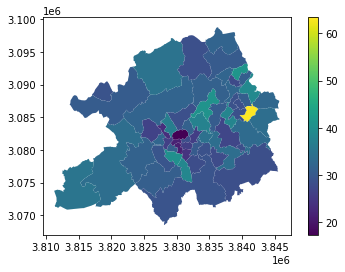

In [22]:
# see how average emission intensity varies through the city
gu_stats.plot(column='emission_ges_5_usages_m2',legend=True)

<AxesSubplot:>

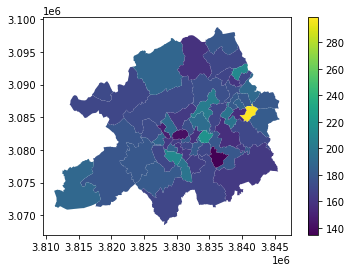

In [23]:
# see how average energy efficiency varies through the city
gu_stats.plot(column='conso_5_usages_ef_m2',legend=True)

In [24]:
# add count of DPEs to the stats by geo unit
N=pd.DataFrame(dpe_gu['geo_unit'].value_counts()).reset_index()
N.rename(columns={'index':'geo_unit','geo_unit':'N'},inplace=True)
gu_stats=gu_stats.merge(N)
gu_stats.head()

,geo_unit,geometry,area,Population,Density,emission_ges_5_usages_m2,conso_5_usages_ef_m2,N
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,28.321199,180.503386,264
1,102,"POLYGON ((3830948.302 3080000.986, 3830842.526...",1.736899,17020.0,9799.0,25.871121,169.616578,588
2,103,"POLYGON ((3830813.962 3079445.052, 3830830.781...",1.332421,20474.0,15366.0,21.321014,160.114032,991
3,104,"POLYGON ((3830131.702 3080002.606, 3830140.054...",1.467545,20511.0,13976.0,31.035073,187.261464,828
4,105,"POLYGON ((3829671.427 3080837.090, 3829662.212...",0.989090,15571.0,15743.0,21.730266,165.512341,519


In [25]:
# so the one geo_unit with very high energy and emission intensity is '149', and this one had 417 observations, so not a small sample, but maybe skewed in terms of age.
# indeed we see the dpes from this location are almost all from <1975
dpe_gu.loc[dpe_gu['geo_unit']==149,'periode_construction_dpe'].value_counts()

1948-1974     288
avant 1948    119
2006-2012       3
1989-2000       3
1978-1982       1
1983-1988       1
1975-1977       1
2013-2021       1
Name: periode_construction_dpe, dtype: int64

In [26]:
# this geo-unit is located mostly within commune of Roubaix
dpe_gu.loc[dpe_gu['geo_unit']==149,'libelle_commune'].value_counts()

Roubaix           402
Lys-lez-Lannoy     10
Hem                 4
Leers               1
Name: libelle_commune, dtype: int64

In [27]:
# mostly gas heating (collective gas might be gas by building)
dpe_gu.loc[dpe_gu['geo_unit']==149,['type_installation_chauffage','type_energie_chauffage']].value_counts()

type_installation_chauffage  type_energie_chauffage
collectif                    gaz                       218
individuel                   gaz                       120
                             electricite                28
collectif                    reseau de chaleur          10
                             electricite                 2
individuel                   bois                        1
                             charbon                     1
                             fioul                       1
dtype: int64

In [28]:
# many of the gas heaters are very old. Less than 15 years old wouldn't count as 'recent' to me
dpe_gu.loc[dpe_gu['geo_unit']==149,['type_energie_chauffage','type_generateur_chauffage_anciennete']].value_counts()

type_energie_chauffage  type_generateur_chauffage_anciennete
gaz                     très ancien                             167
                        récent(<15ans)                          101
                        neuf                                     52
                        ancien                                   18
electricite             neuf                                      3
bois                    neuf                                      1
electricite             récent(<15ans)                            1
fioul                   très ancien                               1
dtype: int64

In [29]:
# many buildings with no wall insulation
dpe_gu.loc[dpe_gu['geo_unit']==149,'type_isolation_mur_exterieur'].value_counts()

non isole    223
ITI           67
inconnu       59
ITE           17
ITI+ITR        1
ITR            1
Name: type_isolation_mur_exterieur, dtype: int64

### 4. Load in EUBUCCO data, prepare to scale the DPE data to the stock level

#### Assumptions/decisions in this section:
 - All buildings with height of 0m in EUBUCCO are assumed to be 1m tall, for the purpose of calculating stories based on height
 - Assume an average floor height of 4m for converting building height to stories, with exception of 1-storey buildings which are assumed to be up to 5m tall
 - Restrict EUBUCCO data to only residential labelled buildings. Assume that buildings with no label are not residential
 - Assume that multi-storey mixed-used partly-residential buildings (buildings that have residential and at least one other use other than annex listed) are residential on all but one floor
 - Assuming that single-storey mixed-used partly residential buildings are 70% residential
 - Assume a constant 1.2 scaling factor between living area and gross floor area in all buildings
 - Estimating based on rules-based algorithm how much of the floor area of mixed-use buildings is residential/non-residential

Next, we load in EUBUCCO data for the same spatial boundary, and see to what extent we can scale up our samples to be comprehensive for each spatial unit

In [30]:
bldg=gpd.read_file('../../MSCA_data/BuildingsDatabase/clips/eubucco_lille.shp')
bldg.head()

,fid,id,height,age,type,id_source,type_sourc,geometry
0,19439901.0,v0.1-FRA.7.2.5.19_1-4528,4.5,NaN,non-residential,BATIMENT0000000288165364,Commercial et services,"POLYGON ((3828709.383 3069743.102, 3828734.808..."
1,19442319.0,v0.1-FRA.7.2.5.19_1-6946,3.3,NaN,None,BATIMENT0000000288165365,Indifférencié,"POLYGON ((3828741.619 3069724.755, 3828755.805..."
2,19439903.0,v0.1-FRA.7.2.5.19_1-4530,0.0,2007.0,residential,BATIMENT0000000288165418,Résidentiel,"POLYGON ((3829149.498 3069720.967, 3829159.681..."
3,19323988.0,v0.1-FRA.7.2.5.13_1-1192,0.0,2006.0,residential,BATIMENT0000000288165415,Résidentiel,"POLYGON ((3829148.454 3069684.635, 3829164.402..."
4,19323943.0,v0.1-FRA.7.2.5.13_1-1147,4.4,1985.0,residential,BATIMENT0000000288165338,Résidentiel,"POLYGON ((3829195.216 3069659.877, 3829195.292..."


In [31]:
# check coverage of relevant attributes in EUBUCCO
print(100*round(sum(bldg['type'].value_counts())/len(bldg),2), '% of buildings have a type attribute')
print(100*round(sum(bldg['age'].value_counts())/len(bldg),3), '% of buildings have an age attribute')
print(100*round(sum(bldg['height'].value_counts())/len(bldg),3), '% of buildings have a height attribute')

70.0 % of buildings have a type attribute
61.3 % of buildings have an age attribute
99.8 % of buildings have a height attribute


In [32]:
# for the purpose of calculating stories, turn all buildings with 0 height or NA height to height of 1m
bldg.loc[bldg['height'].isna(),'height']=1
bldg.loc[bldg['height']==0,'height']=1

In [33]:
# load in the bdtopo file (with the raw building use columns) and the building_construction file which matches building groups with building constructions
# the building construction file is the one that contains building group polygons
# BC = pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/batiment_construction.csv')
BC = import_csv_w_wkt_to_gdf('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/batiment_construction.csv',crs=2154,geometry_col='WKT') # gc means that the specified column is read as a string
BC.to_crs(3035,inplace=True)
BC.head()

,WKT,batiment_construction_id,batiment_groupe_id,code_departement_insee,code_iris,code_commune_insee,s_geom_cstr,hauteur,altitude_sol,fictive_geom_cstr,geometry
0,"MULTIPOLYGON (((648120.2 7104434.6,648120.8 71...",BATIMENT0000000056598726-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,32.0,4.0,7.0,0,"MULTIPOLYGON (((3779363.955 3131157.890, 37793..."
1,"MULTIPOLYGON (((669133.0 7105045.6,669127.6 71...",BATIMENT0000000056596362-2,592604040A0746_e08c048eccb8b8b,59,592600000.0,59260.0,28.0,1.6,0.0,0,"MULTIPOLYGON (((3800273.658 3129748.091, 38002..."
2,MULTIPOLYGON (((655725.5407313 7103268.5745565...,BATIMENT0000000056603258-4,59155000AB0454_c7a93be4dd46566,59,591550101.0,59155.0,14.0,8.0,3.0,0,"MULTIPOLYGON (((3786799.279 3129268.048, 37868..."
3,"MULTIPOLYGON (((704215.0 7036515.8,704215.9388...",BATIMENT0000000046102397-2,uf590280373968_89dcf46922915ba,59,NaN,59028.0,60.0,5.0,NaN,0,"MULTIPOLYGON (((3828606.730 3058253.637, 38286..."
4,MULTIPOLYGON (((703688.537616351 7036434.21480...,BATIMENT0000000046102442-1,uf590280012251_4fca4c9f5acb718,59,590280103.0,NaN,24.0,4.7,22.0,0,"MULTIPOLYGON (((3828076.042 3058222.616, 38280..."


In [34]:
# load data from bdtopo which includes detailed building uses
bdt=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/batiment_groupe_bdtopo_bat.csv')
bdt.head()

,batiment_groupe_id,code_departement_insee,l_nature,l_usage_1,l_usage_2,l_etat,hauteur_mean,altitude_sol_mean
0,59626000ZD0062_81482eddb4148c0,59,"[ ""Fort, blockhaus, casemate"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",5,107.0
1,590430000A0992_c9e95b8a3e782f2,59,"[ ""Chapelle"" ]","[ ""Religieux"" ]",NaN,"[ ""En service"" ]",1,29.0
2,uf592520097169_45a6275f4246c8b,59,"[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",6,18.0
3,uf593080411204_978efb49cb521b7,59,"[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,43.0
4,uf593050411146_854550cccdbe726,59,"[ ""Indifférenciée"" ]","[ ""Résidentiel"" ]",NaN,"[ ""En service"" ]",3,15.0


In [35]:
# combine the building_construction geodataframe and the bdtopo type data
bc_type=BC.merge(bdt)
bc_type.head()

,WKT,batiment_construction_id,batiment_groupe_id,code_departement_insee,code_iris,code_commune_insee,s_geom_cstr,hauteur,altitude_sol,fictive_geom_cstr,geometry,l_nature,l_usage_1,l_usage_2,l_etat,hauteur_mean,altitude_sol_mean
0,"MULTIPOLYGON (((648120.2 7104434.6,648120.8 71...",BATIMENT0000000056598726-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,32.0,4.0,7.0,0,"MULTIPOLYGON (((3779363.955 3131157.890, 37793...","[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0
1,"MULTIPOLYGON (((648104.2 7104432.5,648104.7 71...",BATIMENT0000000056598724-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,32.0,3.9,7.0,0,"MULTIPOLYGON (((3779347.878 3131157.341, 37793...","[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0
2,"MULTIPOLYGON (((648078.1 7104429.7,648072.1 71...",BATIMENT0000000056598731-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,54.0,4.2,7.0,0,"MULTIPOLYGON (((3779321.712 3131157.067, 37793...","[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0
3,"MULTIPOLYGON (((648102.1 7104428.9,648101.7 71...",BATIMENT0000000284074632-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,17.0,4.0,7.0,0,"MULTIPOLYGON (((3779345.450 3131153.964, 37793...","[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0
4,"MULTIPOLYGON (((648093.6 7104428.4,648093.5 71...",BATIMENT0000000284074633-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,15.0,4.3,7.0,0,"MULTIPOLYGON (((3779336.968 3131154.285, 37793...","[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0


In [36]:
# Define Res_mixed (mixed-use buildings which include residential as a use) as any building which has residential in either use, and is not just res + annex or res + na
bc_type['Res_mixed']=((bc_type['l_usage_1'].str.contains('Résidentiel',na=False)) | (bc_type['l_usage_2'].str.contains('Résidentiel',na=False))) & ~((bc_type['l_usage_1']=='[ "Résidentiel" ]') & (bc_type['l_usage_2']=='[ "Annexe" ]')) & ~((bc_type['l_usage_1']=='[ "Résidentiel" ]') & (bc_type['l_usage_2'].isna()))
bc_type['Mainly_Res']=bc_type['l_usage_1'].str.contains('Résidentiel',na=False)
bc_type['use1_first']=bc_type['l_usage_1'].str.slice(stop=9)
bc_type['Res_first']=bc_type['use1_first'].str.contains('Rés',na=False)
bc_type.head()


,WKT,batiment_construction_id,batiment_groupe_id,code_departement_insee,code_iris,code_commune_insee,s_geom_cstr,hauteur,altitude_sol,fictive_geom_cstr,...,l_nature,l_usage_1,l_usage_2,l_etat,hauteur_mean,altitude_sol_mean,Res_mixed,Mainly_Res,use1_first,Res_first
0,"MULTIPOLYGON (((648120.2 7104434.6,648120.8 71...",BATIMENT0000000056598726-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,32.0,4.0,7.0,0,...,"[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0,False,False,"[ ""Indiff",False
1,"MULTIPOLYGON (((648104.2 7104432.5,648104.7 71...",BATIMENT0000000056598724-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,32.0,3.9,7.0,0,...,"[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0,False,False,"[ ""Indiff",False
2,"MULTIPOLYGON (((648078.1 7104429.7,648072.1 71...",BATIMENT0000000056598731-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,54.0,4.2,7.0,0,...,"[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0,False,False,"[ ""Indiff",False
3,"MULTIPOLYGON (((648102.1 7104428.9,648101.7 71...",BATIMENT0000000284074632-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,17.0,4.0,7.0,0,...,"[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0,False,False,"[ ""Indiff",False
4,"MULTIPOLYGON (((648093.6 7104428.4,648093.5 71...",BATIMENT0000000284074633-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,15.0,4.3,7.0,0,...,"[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0,False,False,"[ ""Indiff",False


In [37]:
bc_type[['Res_mixed','Mainly_Res','Res_first']].value_counts()

Res_mixed  Mainly_Res  Res_first
False      True        True         646824
           False       False        251205
True       True        True          68858
                       False         37225
           False       False          8189
dtype: int64

In [38]:
# # identify residential mixed-use buildings as those which have res included in use1 or use2, and excluding those which don't have a use2
# bc_type['Res_mixed']=((bc_type['l_usage_1'].str.contains('Résidentiel',na=False)) | (bc_type['l_usage_2'].str.contains('Résidentiel',na=False))) & (~bc_type['l_usage_2'].isna())
# # for those which are just res + annex, can retain residential label, not convert to mixed use
# bc_type.loc[(bc_type['l_usage_1']=='[ "Résidentiel" ]') & (bc_type['l_usage_2']=='[ "Annexe" ]'),'Res_mixed']=False

# enable merge bw eubucco and batiment_construction_id by removing the last two characteris '-N
bc_type['bc_ids_short']=bc_type['batiment_construction_id'].str.slice(stop=-2)
bc_type.head()

,WKT,batiment_construction_id,batiment_groupe_id,code_departement_insee,code_iris,code_commune_insee,s_geom_cstr,hauteur,altitude_sol,fictive_geom_cstr,...,l_usage_1,l_usage_2,l_etat,hauteur_mean,altitude_sol_mean,Res_mixed,Mainly_Res,use1_first,Res_first,bc_ids_short
0,"MULTIPOLYGON (((648120.2 7104434.6,648120.8 71...",BATIMENT0000000056598726-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,32.0,4.0,7.0,0,...,"[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0,False,False,"[ ""Indiff",False,BATIMENT0000000056598726
1,"MULTIPOLYGON (((648104.2 7104432.5,648104.7 71...",BATIMENT0000000056598724-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,32.0,3.9,7.0,0,...,"[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0,False,False,"[ ""Indiff",False,BATIMENT0000000056598724
2,"MULTIPOLYGON (((648078.1 7104429.7,648072.1 71...",BATIMENT0000000056598731-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,54.0,4.2,7.0,0,...,"[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0,False,False,"[ ""Indiff",False,BATIMENT0000000056598731
3,"MULTIPOLYGON (((648102.1 7104428.9,648101.7 71...",BATIMENT0000000284074632-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,17.0,4.0,7.0,0,...,"[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0,False,False,"[ ""Indiff",False,BATIMENT0000000284074632
4,"MULTIPOLYGON (((648093.6 7104428.4,648093.5 71...",BATIMENT0000000284074633-1,59183380AB0033_00cc16d59008e56,59,591831401.0,59183.0,15.0,4.3,7.0,0,...,"[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,7.0,False,False,"[ ""Indiff",False,BATIMENT0000000284074633


In [39]:
# rename geom column to avoid confusion with eubucco geometry column later
bc_type.rename(columns={'geometry':'bc_geometry'},inplace=True)
bc_type.drop(columns='WKT',inplace=True)

In [40]:
# merge eubucco and the building construction type data. this loses over 30% of eubucco data, as not all of the type data have ids matching to EUBUCCO ids
bldg_type=bldg.merge(bc_type,left_on='id_source',right_on='bc_ids_short')
bldg_type.head(10)

,fid,id,height,age,type,id_source,type_sourc,geometry,batiment_construction_id,batiment_groupe_id,...,l_usage_1,l_usage_2,l_etat,hauteur_mean,altitude_sol_mean,Res_mixed,Mainly_Res,use1_first,Res_first,bc_ids_short
0,19439903.0,v0.1-FRA.7.2.5.19_1-4530,1.0,2007.0,residential,BATIMENT0000000288165418,Résidentiel,"POLYGON ((3829149.498 3069720.967, 3829159.681...",BATIMENT0000000288165418-1,59560000ZI0055_66ff7009560171e,...,"[ ""Résidentiel"" ]",NaN,"[ ""En service"" ]",6,41.0,False,True,"[ ""Réside",True,BATIMENT0000000288165418
1,19323988.0,v0.1-FRA.7.2.5.13_1-1192,1.0,2006.0,residential,BATIMENT0000000288165415,Résidentiel,"POLYGON ((3829148.454 3069684.635, 3829164.402...",BATIMENT0000000288165415-1,59560000ZI0054_0f8cb10d9d0059c,...,"[ ""Résidentiel"" ]",NaN,"[ ""En service"" ]",6,41.0,False,True,"[ ""Réside",True,BATIMENT0000000288165415
2,19323943.0,v0.1-FRA.7.2.5.13_1-1147,4.4,1985.0,residential,BATIMENT0000000288165338,Résidentiel,"POLYGON ((3829195.216 3069659.877, 3829195.292...",BATIMENT0000000288165338-1,590220000A0263_6860356e2b38810,...,"[ ""Résidentiel"" ]","[ ""Annexe"" ]","[ ""En service"" ]",4,43.0,False,True,"[ ""Réside",True,BATIMENT0000000288165338
3,19441971.0,v0.1-FRA.7.2.5.19_1-6598,3.9,1800.0,residential,BATIMENT0000000300636533,Résidentiel,"POLYGON ((3829201.336 3069724.327, 3829209.972...",BATIMENT0000000300636533-3,uf595600226136_30b74b59373e749,...,"[ ""Résidentiel"" ]",NaN,"[ ""En service"" ]",4,43.0,False,True,"[ ""Réside",True,BATIMENT0000000300636533
4,19323948.0,v0.1-FRA.7.2.5.13_1-1152,6.4,1981.0,residential,BATIMENT0000000288165349,Résidentiel,"POLYGON ((3829260.589 3069674.107, 3829260.640...",BATIMENT0000000288165349-1,590220000A0366_cbc96a5f9bf6506,...,"[ ""Résidentiel"" ]","[ ""Annexe"" ]","[ ""En service"" ]",6,43.0,False,True,"[ ""Réside",True,BATIMENT0000000288165349
5,19439866.0,v0.1-FRA.7.2.5.19_1-4493,3.7,1970.0,non-residential,BATIMENT0000000288164860,Annexe,"POLYGON ((3827837.659 3069993.015, 3827834.447...",BATIMENT0000000288164860-1,uf595600424005_47f6c17f3f55b7a,...,"[ ""Annexe"" ]",NaN,"[ ""En service"" ]",4,34.0,False,False,"[ ""Annexe",False,BATIMENT0000000288164860
6,19439875.0,v0.1-FRA.7.2.5.19_1-4502,5.9,1890.0,residential,BATIMENT0000000288164848,Résidentiel,"POLYGON ((3827856.133 3069895.193, 3827881.786...",BATIMENT0000000288164848-1,59560000ZN0042_2aabfbd44b96094,...,"[ ""Résidentiel"" ]",NaN,"[ ""En service"" ]",6,35.0,False,True,"[ ""Réside",True,BATIMENT0000000288164848
7,19442058.0,v0.1-FRA.7.2.5.19_1-6685,7.0,NaN,non-residential,BATIMENT0000000358202246,Commercial et services,"POLYGON ((3828764.378 3069760.711, 3828767.424...",BATIMENT0000000358202246-1,59560000ZI0053_18bac5086362f03,...,"[ ""Commercial et services"" ]",NaN,"[ ""En service"" ]",7,39.0,False,False,"[ ""Commer",False,BATIMENT0000000358202246
8,19437695.0,v0.1-FRA.7.2.5.19_1-2322,4.3,1920.0,non-residential,BATIMENT0000000056801664,Annexe,"POLYGON ((3829239.077 3069860.014, 3829241.731...",BATIMENT0000000056801664-2,uf595600225931_1252f5dfa3fdfb5,...,"[ ""Annexe"" ]",NaN,"[ ""En service"" ]",4,40.0,False,False,"[ ""Annexe",False,BATIMENT0000000056801664
9,19436026.0,v0.1-FRA.7.2.5.19_1-653,5.2,NaN,None,BATIMENT0000000288164618,Indifférencié,"POLYGON ((3829243.654 3069811.099, 3829255.874...",BATIMENT0000000288164618-1,595600000C0254_a973dead994cc0d,...,"[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",5,40.0,False,False,"[ ""Indiff",False,BATIMENT0000000288164618


In [41]:
# merge just the 'Res_mixed' building type data into EUBUCCO, this time keeping all of the EUBUCCO buidlings, so that we can calculate area sums without excluding buildings
bldg2=bldg.merge(bldg_type.loc[:,['bc_ids_short','bc_geometry','batiment_construction_id','l_usage_1','l_usage_2','Res_mixed','Mainly_Res','Res_first']],how='left',left_on='id_source',right_on='bc_ids_short')
bldg2.head()

,fid,id,height,age,type,id_source,type_sourc,geometry,bc_ids_short,bc_geometry,batiment_construction_id,l_usage_1,l_usage_2,Res_mixed,Mainly_Res,Res_first
0,19439901.0,v0.1-FRA.7.2.5.19_1-4528,4.5,NaN,non-residential,BATIMENT0000000288165364,Commercial et services,"POLYGON ((3828709.383 3069743.102, 3828734.808...",NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
1,19442319.0,v0.1-FRA.7.2.5.19_1-6946,3.3,NaN,None,BATIMENT0000000288165365,Indifférencié,"POLYGON ((3828741.619 3069724.755, 3828755.805...",NaN,None,NaN,NaN,NaN,NaN,NaN,NaN
2,19439903.0,v0.1-FRA.7.2.5.19_1-4530,1.0,2007.0,residential,BATIMENT0000000288165418,Résidentiel,"POLYGON ((3829149.498 3069720.967, 3829159.681...",BATIMENT0000000288165418,"MULTIPOLYGON (((3829149.498 3069720.967, 38291...",BATIMENT0000000288165418-1,"[ ""Résidentiel"" ]",NaN,False,True,True
3,19323988.0,v0.1-FRA.7.2.5.13_1-1192,1.0,2006.0,residential,BATIMENT0000000288165415,Résidentiel,"POLYGON ((3829148.454 3069684.635, 3829164.402...",BATIMENT0000000288165415,"MULTIPOLYGON (((3829148.454 3069684.635, 38291...",BATIMENT0000000288165415-1,"[ ""Résidentiel"" ]",NaN,False,True,True
4,19323943.0,v0.1-FRA.7.2.5.13_1-1147,4.4,1985.0,residential,BATIMENT0000000288165338,Résidentiel,"POLYGON ((3829195.216 3069659.877, 3829195.292...",BATIMENT0000000288165338,"MULTIPOLYGON (((3829195.216 3069659.877, 38292...",BATIMENT0000000288165338-1,"[ ""Résidentiel"" ]","[ ""Annexe"" ]",False,True,True


In [42]:
# this leaves us with a slightly larger EUBUCCO buildings gdf, as some EUBUCCO building geometries are included multiple times
# Why? Because the eubucco ids are matched with a shortened bc_id. i.e. there are further specifications in the bc_ids which are not considered by eubucco.
bldg2['fid'].value_counts().head()

19225267.0    9
19547426.0    9
19225242.0    9
19141980.0    9
19153861.0    9
Name: fid, dtype: int64

In [43]:
# e.g. buildings which had two building_construction ids (before being shortened), and can end up with two different classifications for 'Res_mixed', 
bldg2.loc[bldg2['fid']==19023914.0,]

,fid,id,height,age,type,id_source,type_sourc,geometry,bc_ids_short,bc_geometry,batiment_construction_id,l_usage_1,l_usage_2,Res_mixed,Mainly_Res,Res_first
499567,19023914.0,v0.1-FRA.7.2.5.1_1-1614,6.5,1949.0,non-residential,BATIMENT0000000280392079,Annexe,"POLYGON ((3818818.047 3087788.489, 3818812.974...",BATIMENT0000000280392079,"MULTIPOLYGON (((3818819.946 3087807.374, 38188...",BATIMENT0000000280392079-2,"[ ""Résidentiel"", ""Annexe"" ]","[ ""Commercial et services"" ]",True,True,True
499568,19023914.0,v0.1-FRA.7.2.5.1_1-1614,6.5,1949.0,non-residential,BATIMENT0000000280392079,Annexe,"POLYGON ((3818818.047 3087788.489, 3818812.974...",BATIMENT0000000280392079,"MULTIPOLYGON (((3818812.974 3087793.091, 38188...",BATIMENT0000000280392079-4,"[ ""Annexe"" ]",NaN,False,False,False


In [44]:
dupes=pd.DataFrame(bldg2['fid'].value_counts()).reset_index()
dupes=dupes.loc[dupes['fid']>1,:]
dupes.rename(columns={'index':'fid','fid':'count'},inplace=True)
dupes.head()

,fid,count
0,19225267.0,9
1,19547426.0,9
2,19225242.0,9
3,19141980.0,9
4,19153861.0,9


In [45]:
# replace the EUBUCCO geoms with the bdtopo bc ones for buildings which have multiple rows for a single eubucco id, to avoid overestimating area
bldg2.loc[bldg2['fid'].isin(dupes['fid']),'geometry']=bldg2.loc[bldg2['fid'].isin(dupes['fid']),'bc_geometry']
bldg2.loc[bldg2['fid'].isin(dupes['fid']),]

,fid,id,height,age,type,id_source,type_sourc,geometry,bc_ids_short,bc_geometry,batiment_construction_id,l_usage_1,l_usage_2,Res_mixed,Mainly_Res,Res_first
62,19436043.0,v0.1-FRA.7.2.5.19_1-670,3.9,NaN,None,BATIMENT0000000288164513,Indifférencié,"MULTIPOLYGON (((3829381.764 3070043.247, 38293...",BATIMENT0000000288164513,"MULTIPOLYGON (((3829381.764 3070043.247, 38293...",BATIMENT0000000288164513-2,"[ ""Résidentiel"", ""Commercial et services"", ""In...",NaN,True,True,True
63,19436043.0,v0.1-FRA.7.2.5.19_1-670,3.9,NaN,None,BATIMENT0000000288164513,Indifférencié,"MULTIPOLYGON (((3829382.685 3070042.106, 38293...",BATIMENT0000000288164513,"MULTIPOLYGON (((3829382.685 3070042.106, 38293...",BATIMENT0000000288164513-1,"[ ""Commercial et services"", ""Indifférencié"", ""...",NaN,True,True,False
80,19439735.0,v0.1-FRA.7.2.5.19_1-4362,3.8,1974.0,residential,BATIMENT0000000288164545,Résidentiel,"MULTIPOLYGON (((3829385.904 3070153.351, 38293...",BATIMENT0000000288164545,"MULTIPOLYGON (((3829385.904 3070153.351, 38293...",BATIMENT0000000288164545-1,"[ ""Résidentiel"", ""Commercial et services"" ]",NaN,True,True,True
81,19439735.0,v0.1-FRA.7.2.5.19_1-4362,3.8,1974.0,residential,BATIMENT0000000288164545,Résidentiel,"MULTIPOLYGON (((3829389.496 3070158.312, 38293...",BATIMENT0000000288164545,"MULTIPOLYGON (((3829389.496 3070158.312, 38293...",BATIMENT0000000288164545-2,"[ ""Résidentiel"" ]",NaN,False,True,True
374,19114224.0,v0.1-FRA.7.2.5.4_1-13986,4.0,NaN,None,BATIMENT0000000300639218,Indifférencié,"MULTIPOLYGON (((3818969.873 3073259.089, 38189...",BATIMENT0000000300639218,"MULTIPOLYGON (((3818969.873 3073259.089, 38189...",BATIMENT0000000300639218-2,"[ ""Indifférencié"" ]",NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522116,19044129.0,v0.1-FRA.7.2.5.1_1-21829,3.5,2013.0,residential,BATIMENT0000000358207905,Résidentiel,"MULTIPOLYGON (((3817233.077 3087680.443, 38172...",BATIMENT0000000358207905,"MULTIPOLYGON (((3817233.077 3087680.443, 38172...",BATIMENT0000000358207905-2,"[ ""Résidentiel"" ]",NaN,False,True,True
522169,19044174.0,v0.1-FRA.7.2.5.1_1-21874,4.6,2010.0,residential,BATIMENT0000000358207970,Résidentiel,"MULTIPOLYGON (((3817687.924 3087864.515, 38176...",BATIMENT0000000358207970,"MULTIPOLYGON (((3817687.924 3087864.515, 38176...",BATIMENT0000000358207970-1,"[ ""Résidentiel"" ]",NaN,False,True,True
522170,19044174.0,v0.1-FRA.7.2.5.1_1-21874,4.6,2010.0,residential,BATIMENT0000000358207970,Résidentiel,"MULTIPOLYGON (((3817700.693 3087865.245, 38177...",BATIMENT0000000358207970,"MULTIPOLYGON (((3817700.693 3087865.245, 38177...",BATIMENT0000000358207970-2,"[ ""Résidentiel"" ]",NaN,False,True,True
522413,19042484.0,v0.1-FRA.7.2.5.1_1-20184,5.2,2015.0,residential,BATIMENT0000000358208061,Résidentiel,"MULTIPOLYGON (((3817252.648 3087595.569, 38172...",BATIMENT0000000358208061,"MULTIPOLYGON (((3817252.648 3087595.569, 38172...",BATIMENT0000000358208061-1,"[ ""Résidentiel"" ]",NaN,False,True,True


In [46]:
# we see that the prior algorithm for determining type in eubucco was more conservative in labelling buildings as residential.
bldg2.loc[(bldg2['Res_mixed']==True) & (bldg2['Mainly_Res']==True),'type'].value_counts()

residential        20752
non-residential     5247
Name: type, dtype: int64

In [47]:
# even some buildings which had residential as the 'first' use in use_1 are not identified in EUBUCCO as residential. this could again be related to the splitting of EUBUCCO geometries into multiple geometries with potentially different uses.
bldg2.loc[(bldg2['Res_first']==True),'type'].value_counts() 

residential        261100
non-residential      2301
Name: type, dtype: int64

In [48]:
# here is a sample of buildings we would say are (at least partially) residential, which eubucco does not agree on
bldg2.loc[(bldg2['Res_mixed']==True) & (bldg2['Mainly_Res']==True) & (bldg2['type']!='residential'),]

,fid,id,height,age,type,id_source,type_sourc,geometry,bc_ids_short,bc_geometry,batiment_construction_id,l_usage_1,l_usage_2,Res_mixed,Mainly_Res,Res_first
55,19435540.0,v0.1-FRA.7.2.5.19_1-167,1.0,NaN,non-residential,BATIMENT0000000288164516,Commercial et services,"POLYGON ((3829380.050 3070022.034, 3829380.140...",BATIMENT0000000288164516,"MULTIPOLYGON (((3829380.050 3070022.034, 38293...",BATIMENT0000000288164516-1,"[ ""Commercial et services"", ""Indifférencié"", ""...",NaN,True,True,False
58,19435538.0,v0.1-FRA.7.2.5.19_1-165,3.8,NaN,non-residential,BATIMENT0000000288164509,Commercial et services,"POLYGON ((3829422.100 3070035.264, 3829402.443...",BATIMENT0000000288164509,"MULTIPOLYGON (((3829422.100 3070035.264, 38294...",BATIMENT0000000288164509-1,"[ ""Commercial et services"", ""Indifférencié"", ""...",NaN,True,True,False
62,19436043.0,v0.1-FRA.7.2.5.19_1-670,3.9,NaN,None,BATIMENT0000000288164513,Indifférencié,"MULTIPOLYGON (((3829381.764 3070043.247, 38293...",BATIMENT0000000288164513,"MULTIPOLYGON (((3829381.764 3070043.247, 38293...",BATIMENT0000000288164513-2,"[ ""Résidentiel"", ""Commercial et services"", ""In...",NaN,True,True,True
63,19436043.0,v0.1-FRA.7.2.5.19_1-670,3.9,NaN,None,BATIMENT0000000288164513,Indifférencié,"MULTIPOLYGON (((3829382.685 3070042.106, 38293...",BATIMENT0000000288164513,"MULTIPOLYGON (((3829382.685 3070042.106, 38293...",BATIMENT0000000288164513-1,"[ ""Commercial et services"", ""Indifférencié"", ""...",NaN,True,True,False
64,19439723.0,v0.1-FRA.7.2.5.19_1-4350,3.8,NaN,non-residential,BATIMENT0000000288164511,Commercial et services,"POLYGON ((3829380.819 3070037.516, 3829380.034...",BATIMENT0000000288164511,"MULTIPOLYGON (((3829380.819 3070037.516, 38293...",BATIMENT0000000288164511-2,"[ ""Résidentiel"", ""Commercial et services"", ""In...",NaN,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522499,19051382.0,v0.1-FRA.7.2.5.1_1-29082,4.9,NaN,None,BATIMENT0000000358209172,Indifférencié,"POLYGON ((3817710.918 3087937.570, 3817715.269...",BATIMENT0000000358209172,"MULTIPOLYGON (((3817710.918 3087937.570, 38177...",BATIMENT0000000358209172-1,"[ ""Résidentiel"", ""Indifférencié"" ]",NaN,True,True,True
522526,19051383.0,v0.1-FRA.7.2.5.1_1-29083,11.9,NaN,None,BATIMENT0000000280390024,Indifférencié,"POLYGON ((3818092.180 3087884.659, 3818094.115...",BATIMENT0000000280390024,"MULTIPOLYGON (((3818092.180 3087884.659, 38180...",BATIMENT0000000280390024-1,"[ ""Résidentiel"", ""Indifférencié"" ]",NaN,True,True,True
522533,19051433.0,v0.1-FRA.7.2.5.1_1-29133,3.8,NaN,None,BATIMENT0000000280389973,Indifférencié,"POLYGON ((3818124.465 3087959.529, 3818129.780...",BATIMENT0000000280389973,"MULTIPOLYGON (((3818124.465 3087959.529, 38181...",BATIMENT0000000280389973-2,"[ ""Résidentiel"", ""Indifférencié"", ""Annexe"" ]",NaN,True,True,True
522534,19051435.0,v0.1-FRA.7.2.5.1_1-29135,4.3,NaN,None,BATIMENT0000000280389976,Indifférencié,"POLYGON ((3818139.301 3087946.964, 3818140.781...",BATIMENT0000000280389976,"MULTIPOLYGON (((3818139.301 3087946.964, 38181...",BATIMENT0000000280389976-1,"[ ""Résidentiel"", ""Indifférencié"", ""Annexe"" ]",NaN,True,True,True


In [49]:
# redefine what is classed as a residential building; based on what we see in the use columns
# we end up increasing the count of 'residential' buildings by about 2.5%
bldg2['type_new']=bldg2['type'].copy()
bldg2.loc[bldg2['Res_mixed']==True,'type_new']='residential'
bldg2[['type','type_new']].value_counts()

type             type_new       
residential      residential        285621
non-residential  non-residential     71919
                 residential          7127
dtype: int64

In [50]:
# prepare dataframe to estimate % coverage of type/age labels by geo-unit
bldg2['Center']=bldg2.centroid
bldg2.set_geometry('Center',inplace=True)
bldg2_gu=gpd.sjoin(bldg2,gu.loc[:,['geo_unit','geometry']])

bldg2_gu.set_geometry('geometry',inplace=True)
bldg2_gu.head()

,fid,id,height,age,type,id_source,type_sourc,geometry,bc_ids_short,bc_geometry,batiment_construction_id,l_usage_1,l_usage_2,Res_mixed,Mainly_Res,Res_first,type_new,Center,index_right,geo_unit
0,19439901.0,v0.1-FRA.7.2.5.19_1-4528,4.5,NaN,non-residential,BATIMENT0000000288165364,Commercial et services,"POLYGON ((3828709.383 3069743.102, 3828734.808...",NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,non-residential,POINT (3828720.173 3069732.445),30,131
1,19442319.0,v0.1-FRA.7.2.5.19_1-6946,3.3,NaN,None,BATIMENT0000000288165365,Indifférencié,"POLYGON ((3828741.619 3069724.755, 3828755.805...",NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,None,POINT (3828746.700 3069717.174),30,131
2,19439903.0,v0.1-FRA.7.2.5.19_1-4530,1.0,2007.0,residential,BATIMENT0000000288165418,Résidentiel,"POLYGON ((3829149.498 3069720.967, 3829159.681...",BATIMENT0000000288165418,"MULTIPOLYGON (((3829149.498 3069720.967, 38291...",BATIMENT0000000288165418-1,"[ ""Résidentiel"" ]",NaN,False,True,True,residential,POINT (3829154.337 3069714.338),30,131
3,19323988.0,v0.1-FRA.7.2.5.13_1-1192,1.0,2006.0,residential,BATIMENT0000000288165415,Résidentiel,"POLYGON ((3829148.454 3069684.635, 3829164.402...",BATIMENT0000000288165415,"MULTIPOLYGON (((3829148.454 3069684.635, 38291...",BATIMENT0000000288165415-1,"[ ""Résidentiel"" ]",NaN,False,True,True,residential,POINT (3829156.539 3069680.471),30,131
4,19323943.0,v0.1-FRA.7.2.5.13_1-1147,4.4,1985.0,residential,BATIMENT0000000288165338,Résidentiel,"POLYGON ((3829195.216 3069659.877, 3829195.292...",BATIMENT0000000288165338,"MULTIPOLYGON (((3829195.216 3069659.877, 38292...",BATIMENT0000000288165338-1,"[ ""Résidentiel"" ]","[ ""Annexe"" ]",False,True,True,residential,POINT (3829197.558 3069664.696),30,131


In [51]:
# estimate % coverage of type/age labels by geo-unit
bldg_type=pd.DataFrame(bldg2_gu.groupby('geo_unit')['type'].count()).reset_index()
bldg_age=pd.DataFrame(bldg2_gu.groupby('geo_unit')['age'].count()).reset_index()
N_bldg=pd.DataFrame(bldg2_gu.groupby('geo_unit')['id'].count()).reset_index()
N_bldg.rename(columns={'id':'count'},inplace=True)
bldg_gu_stats=N_bldg.merge(bldg_type)
bldg_gu_stats=bldg_gu_stats.merge(bldg_age)
bldg_gu_stats['type_cov']=bldg_gu_stats['type']/bldg_gu_stats['count']
bldg_gu_stats['age_cov']=bldg_gu_stats['age']/bldg_gu_stats['count']

bldg_gu_stats

,geo_unit,count,type,age,type_cov,age_cov
0,101,1580,1199,915,0.758861,0.579114
1,102,2392,1761,1464,0.736204,0.612040
2,103,5847,4069,3730,0.695912,0.637934
3,104,4903,3260,2883,0.664899,0.588007
4,105,2667,1945,1660,0.729284,0.622422
5,106,4141,2861,2332,0.690896,0.563149
6,107,5845,4016,3510,0.687083,0.600513
7,108,7378,5408,4988,0.732990,0.676064
8,109,4682,3084,2677,0.658693,0.571764
9,110,5474,3493,2902,0.638107,0.530142


In [52]:
# make a gdf of residential buildings only
bldg_res=bldg2.loc[bldg2['type_new']=='residential',]
bldg_res.head()

,fid,id,height,age,type,id_source,type_sourc,geometry,bc_ids_short,bc_geometry,batiment_construction_id,l_usage_1,l_usage_2,Res_mixed,Mainly_Res,Res_first,type_new,Center
2,19439903.0,v0.1-FRA.7.2.5.19_1-4530,1.0,2007.0,residential,BATIMENT0000000288165418,Résidentiel,"POLYGON ((3829149.498 3069720.967, 3829159.681...",BATIMENT0000000288165418,"MULTIPOLYGON (((3829149.498 3069720.967, 38291...",BATIMENT0000000288165418-1,"[ ""Résidentiel"" ]",NaN,False,True,True,residential,POINT (3829154.337 3069714.338)
3,19323988.0,v0.1-FRA.7.2.5.13_1-1192,1.0,2006.0,residential,BATIMENT0000000288165415,Résidentiel,"POLYGON ((3829148.454 3069684.635, 3829164.402...",BATIMENT0000000288165415,"MULTIPOLYGON (((3829148.454 3069684.635, 38291...",BATIMENT0000000288165415-1,"[ ""Résidentiel"" ]",NaN,False,True,True,residential,POINT (3829156.539 3069680.471)
4,19323943.0,v0.1-FRA.7.2.5.13_1-1147,4.4,1985.0,residential,BATIMENT0000000288165338,Résidentiel,"POLYGON ((3829195.216 3069659.877, 3829195.292...",BATIMENT0000000288165338,"MULTIPOLYGON (((3829195.216 3069659.877, 38292...",BATIMENT0000000288165338-1,"[ ""Résidentiel"" ]","[ ""Annexe"" ]",False,True,True,residential,POINT (3829197.558 3069664.696)
5,19441971.0,v0.1-FRA.7.2.5.19_1-6598,3.9,1800.0,residential,BATIMENT0000000300636533,Résidentiel,"POLYGON ((3829201.336 3069724.327, 3829209.972...",BATIMENT0000000300636533,"MULTIPOLYGON (((3829207.615 3069725.037, 38292...",BATIMENT0000000300636533-3,"[ ""Résidentiel"" ]",NaN,False,True,True,residential,POINT (3829207.785 3069714.595)
6,19323948.0,v0.1-FRA.7.2.5.13_1-1152,6.4,1981.0,residential,BATIMENT0000000288165349,Résidentiel,"POLYGON ((3829260.589 3069674.107, 3829260.640...",BATIMENT0000000288165349,"MULTIPOLYGON (((3829264.571 3069672.496, 38292...",BATIMENT0000000288165349-1,"[ ""Résidentiel"" ]","[ ""Annexe"" ]",False,True,True,residential,POINT (3829255.270 3069679.283)


In [53]:
dupe_bc_id=bldg_res.loc[bldg_res['fid'].isin(dupes['fid']),'bc_ids_short'].drop_duplicates()
dupe_bc_id

62        BATIMENT0000000288164513
80        BATIMENT0000000288164545
377       BATIMENT0000000300639245
401       BATIMENT0000000056792649
465       BATIMENT0000002207372089
                    ...           
522107    BATIMENT0000000358207961
522113    BATIMENT0000000358207903
522115    BATIMENT0000000358207905
522169    BATIMENT0000000358207970
522413    BATIMENT0000000358208061
Name: bc_ids_short, Length: 2608, dtype: object

In [54]:
# reset df names
bldg0=bldg.copy()
bldg=bldg_res.copy()

In [55]:
bldg.set_geometry('geometry',inplace=True)

In [56]:
# calculate footprint areas according to eubucco geometries, only replacing with bdtopo bc geometries for those that have multipled eubucco ids
bldg['Footprint']=bldg.area

In [57]:
# calculate building storeies, and thus floor area
bldg['Stories']=np.ceil(bldg['height']/4)
# insert exception for buildings of height 4-5m, which are unlikely to have 2 stories
bldg.loc[bldg['height']<=5,'Stories']=1
bldg['Floor_area']=bldg['Footprint']*bldg['Stories']
bldg['Center']=bldg.centroid
bldg.head()

,fid,id,height,age,type,id_source,type_sourc,geometry,bc_ids_short,bc_geometry,...,l_usage_1,l_usage_2,Res_mixed,Mainly_Res,Res_first,type_new,Center,Footprint,Stories,Floor_area
2,19439903.0,v0.1-FRA.7.2.5.19_1-4530,1.0,2007.0,residential,BATIMENT0000000288165418,Résidentiel,"POLYGON ((3829149.498 3069720.967, 3829159.681...",BATIMENT0000000288165418,"MULTIPOLYGON (((3829149.498 3069720.967, 38291...",...,"[ ""Résidentiel"" ]",NaN,False,True,True,residential,POINT (3829154.337 3069714.338),136.628575,1.0,136.628575
3,19323988.0,v0.1-FRA.7.2.5.13_1-1192,1.0,2006.0,residential,BATIMENT0000000288165415,Résidentiel,"POLYGON ((3829148.454 3069684.635, 3829164.402...",BATIMENT0000000288165415,"MULTIPOLYGON (((3829148.454 3069684.635, 38291...",...,"[ ""Résidentiel"" ]",NaN,False,True,True,residential,POINT (3829156.539 3069680.471),151.302895,1.0,151.302895
4,19323943.0,v0.1-FRA.7.2.5.13_1-1147,4.4,1985.0,residential,BATIMENT0000000288165338,Résidentiel,"POLYGON ((3829195.216 3069659.877, 3829195.292...",BATIMENT0000000288165338,"MULTIPOLYGON (((3829195.216 3069659.877, 38292...",...,"[ ""Résidentiel"" ]","[ ""Annexe"" ]",False,True,True,residential,POINT (3829197.558 3069664.696),185.451388,1.0,185.451388
5,19441971.0,v0.1-FRA.7.2.5.19_1-6598,3.9,1800.0,residential,BATIMENT0000000300636533,Résidentiel,"POLYGON ((3829201.336 3069724.327, 3829209.972...",BATIMENT0000000300636533,"MULTIPOLYGON (((3829207.615 3069725.037, 38292...",...,"[ ""Résidentiel"" ]",NaN,False,True,True,residential,POINT (3829207.785 3069714.595),169.481009,1.0,169.481009
6,19323948.0,v0.1-FRA.7.2.5.13_1-1152,6.4,1981.0,residential,BATIMENT0000000288165349,Résidentiel,"POLYGON ((3829260.589 3069674.107, 3829260.640...",BATIMENT0000000288165349,"MULTIPOLYGON (((3829264.571 3069672.496, 38292...",...,"[ ""Résidentiel"" ]","[ ""Annexe"" ]",False,True,True,residential,POINT (3829255.270 3069679.283),170.907529,2.0,341.815058


In [58]:
bldg['Floor_area'].sum()

65361487.24133618

Here we implement a rules-based algorithm to reduce estimates of residential floor area in mixed-use multi-story buildings. 
Algorithm is up for debate

In [59]:
# those that have >1 storey, and have res as the first use, we assume 1 storey is non-residential
bldg.loc[(bldg['Res_mixed']==True) & (bldg['Res_first']==True) & (bldg['Stories']>1),'Floor_area']=(bldg.loc[(bldg['Res_mixed']==True) & (bldg['Res_first']==True) & (bldg['Stories']>1),'Stories']-1)*bldg.loc[(bldg['Res_mixed']==True) & (bldg['Res_first']==True) & (bldg['Stories']>1),'Footprint']
bldg['Floor_area'].sum()

62687822.687364615

In [60]:
# those that have >2 storey, and have res as a main use but not the first use, we assume 2 storeys are non-residential
bldg.loc[(bldg['Res_mixed']==True) & (bldg['Res_first']==False) & (bldg['Mainly_Res']==True) & (bldg['Stories']>2),'Floor_area']=(bldg.loc[(bldg['Res_mixed']==True) & (bldg['Res_first']==False) & (bldg['Mainly_Res']==True) & (bldg['Stories']>2),'Stories']-2)*bldg.loc[(bldg['Res_mixed']==True) & (bldg['Res_first']==False) & (bldg['Mainly_Res']==True) & (bldg['Stories']>2),'Footprint']
bldg['Floor_area'].sum()

60104807.83792928

In [61]:
# those that have 2 storeys, and have res as a main use but not the first use, we assume 1 storey is non-residential
bldg.loc[(bldg['Res_mixed']==True) & (bldg['Res_first']==False) & (bldg['Mainly_Res']==True) & (bldg['Stories']==2),'Floor_area']=(bldg.loc[(bldg['Res_mixed']==True) & (bldg['Res_first']==False) & (bldg['Mainly_Res']==True) & (bldg['Stories']==2),'Stories']-1)*bldg.loc[(bldg['Res_mixed']==True) & (bldg['Res_first']==False) & (bldg['Mainly_Res']==True) & (bldg['Stories']==2),'Footprint']
bldg['Floor_area'].sum()

59181716.800958574

In [62]:
# those that have >1 storey, and don't have res as a main use, we assume only 1 storey is residential
bldg.loc[(bldg['Res_mixed']==True) & (bldg['Stories']>1) & (bldg['Mainly_Res']==False),'Floor_area']=bldg.loc[(bldg['Res_mixed']==True) & (bldg['Stories']>1) & (bldg['Mainly_Res']==False) ,'Footprint']
bldg['Floor_area'].sum()

57549034.73862522

In [63]:
# those that are 1 storey, and have res as first use, assume 75% of floor area is residential
bldg.loc[(bldg['Res_mixed']==True) & (bldg['Res_first']==True) & (bldg['Stories']==1),'Floor_area']=bldg.loc[(bldg['Res_mixed']==True) & (bldg['Res_first']==True) & (bldg['Stories']==1),'Footprint']*0.75
bldg['Floor_area'].sum()

57333284.12988023

In [64]:
# those that are 1 storey, and don't have res as a main use, assume 20% of floor area is residential
bldg.loc[(bldg['Res_mixed']==True) & (bldg['Mainly_Res']==False) & (bldg['Stories']==1),'Floor_area']=bldg.loc[(bldg['Res_mixed']==True) & (bldg['Mainly_Res']==False)  & (bldg['Stories']==1),'Footprint']*0.2
bldg['Floor_area'].sum()

57144986.03811323

In [65]:
# if we only consider those identified in EUBUCCO as residential, total res floor area is 9% lower
bldg.loc[bldg['type']=='residential','Floor_area'].sum()

52212474.38655079

In [66]:
## join EUBUCCO data to the spatial units
# setting centroid as bldg geometry avoids buildings being mapped to multiple geounits
bldg.rename(columns={'geometry':'bldg_footprint'},inplace=True)
bldg.set_geometry('Center',inplace=True)

bldg_gu=gpd.sjoin(bldg,gu.loc[:,['geo_unit','geometry']])
bldg_gu.drop(columns='index_right',inplace=True)
bldg_gu.head()

,fid,id,height,age,type,id_source,type_sourc,bldg_footprint,bc_ids_short,bc_geometry,...,l_usage_2,Res_mixed,Mainly_Res,Res_first,type_new,Center,Footprint,Stories,Floor_area,geo_unit
2,19439903.0,v0.1-FRA.7.2.5.19_1-4530,1.0,2007.0,residential,BATIMENT0000000288165418,Résidentiel,"POLYGON ((3829149.498 3069720.967, 3829159.681...",BATIMENT0000000288165418,"MULTIPOLYGON (((3829149.498 3069720.967, 38291...",...,NaN,False,True,True,residential,POINT (3829154.337 3069714.338),136.628575,1.0,136.628575,131
3,19323988.0,v0.1-FRA.7.2.5.13_1-1192,1.0,2006.0,residential,BATIMENT0000000288165415,Résidentiel,"POLYGON ((3829148.454 3069684.635, 3829164.402...",BATIMENT0000000288165415,"MULTIPOLYGON (((3829148.454 3069684.635, 38291...",...,NaN,False,True,True,residential,POINT (3829156.539 3069680.471),151.302895,1.0,151.302895,131
4,19323943.0,v0.1-FRA.7.2.5.13_1-1147,4.4,1985.0,residential,BATIMENT0000000288165338,Résidentiel,"POLYGON ((3829195.216 3069659.877, 3829195.292...",BATIMENT0000000288165338,"MULTIPOLYGON (((3829195.216 3069659.877, 38292...",...,"[ ""Annexe"" ]",False,True,True,residential,POINT (3829197.558 3069664.696),185.451388,1.0,185.451388,131
5,19441971.0,v0.1-FRA.7.2.5.19_1-6598,3.9,1800.0,residential,BATIMENT0000000300636533,Résidentiel,"POLYGON ((3829201.336 3069724.327, 3829209.972...",BATIMENT0000000300636533,"MULTIPOLYGON (((3829207.615 3069725.037, 38292...",...,NaN,False,True,True,residential,POINT (3829207.785 3069714.595),169.481009,1.0,169.481009,131
6,19323948.0,v0.1-FRA.7.2.5.13_1-1152,6.4,1981.0,residential,BATIMENT0000000288165349,Résidentiel,"POLYGON ((3829260.589 3069674.107, 3829260.640...",BATIMENT0000000288165349,"MULTIPOLYGON (((3829264.571 3069672.496, 38292...",...,"[ ""Annexe"" ]",False,True,True,residential,POINT (3829255.270 3069679.283),170.907529,2.0,341.815058,131


In [67]:
# define a 'vintage' column to match the `periode_construction_dpe` dpe variable
bldg_gu['vintage']='unknown'
bldg_gu.loc[bldg_gu['age']<1948,'vintage']='<1948'
bldg_gu.loc[(bldg_gu['age']>1947) & (bldg_gu['age']<1975),'vintage']='1948-1974'
bldg_gu.loc[(bldg_gu['age']>1974) & (bldg_gu['age']<1978),'vintage']='1975-1977'
bldg_gu.loc[(bldg_gu['age']>1977) & (bldg_gu['age']<1983),'vintage']='1978-1982'
bldg_gu.loc[(bldg_gu['age']>1982) & (bldg_gu['age']<1989),'vintage']='1983-1988'
bldg_gu.loc[(bldg_gu['age']>1988) & (bldg_gu['age']<2001),'vintage']='1989-2000'
bldg_gu.loc[(bldg_gu['age']>2000) & (bldg_gu['age']<2006),'vintage']='2001-2005'
bldg_gu.loc[(bldg_gu['age']>2005) & (bldg_gu['age']<2013),'vintage']='2006-2012'
bldg_gu.loc[(bldg_gu['age']>2012) & (bldg_gu['age']<2022),'vintage']='2013-2021'
bldg_gu.loc[bldg_gu['age']>2021,'vintage']='2022+'
bldg_gu['vintage'].value_counts()

<1948        146494
1948-1974     67008
1989-2000     17347
unknown       15632
1983-1988     13402
1978-1982     12089
2006-2012      9941
1975-1977      7396
2001-2005      7177
2013-2021      3617
Name: vintage, dtype: int64

In [68]:
# remove buildings with footprints less than 10m2, as these are again probably not residential buildings, but garages, greenhouses, sheds, etc. This removes <1% of buildings
print(len(bldg_gu))
bldg_gu=bldg_gu.loc[bldg_gu['Footprint']>=10,:]
print(len(bldg_gu))

300103
298660


In [69]:
# for browsing purposes
bldg_gu_df=pd.DataFrame(bldg_gu.drop(columns=['bldg_footprint','Center','bc_geometry','id_source','id']))

In [70]:
# calculate stats for residential buildings in eubucco
res_age=pd.DataFrame(bldg_gu.groupby('geo_unit')['age'].count()).reset_index()
N_res=pd.DataFrame(bldg_gu.groupby('geo_unit')['id'].count()).reset_index()
N_res.rename(columns={'id':'count'},inplace=True)

res_gu_stats=N_res.merge(res_age)
res_gu_stats['age_cov']=res_gu_stats['age']/res_gu_stats['count']

# for labelled residential buildings, age coverage is very good.
res_gu_stats.head()

,geo_unit,count,age,age_cov
0,101,773,680,0.879690
1,102,1529,1363,0.891432
2,103,3890,3543,0.910797
3,104,3040,2718,0.894079
4,105,1766,1546,0.875425


In [71]:
# calculate vintage shares in each spatial unit from EUBUCCO data
res_vint=pd.DataFrame(bldg_gu.groupby('geo_unit')['vintage'].value_counts())
res_vint.rename(columns={'vintage':'count'},inplace=True)
res_vint.reset_index(inplace=True)

res_vint=res_vint.merge(res_gu_stats.loc[:,['geo_unit','count']].rename(columns={'count':'total'}))
res_vint['vint_share']=res_vint['count']/res_vint['total']
res_vint

,geo_unit,vintage,count,total,vint_share
0,101,<1948,549,773,0.710220
1,101,unknown,93,773,0.120310
2,101,1989-2000,45,773,0.058215
3,101,1948-1974,41,773,0.053040
4,101,2001-2005,23,773,0.029754
...,...,...,...,...,...
565,157,1983-1988,316,5960,0.053020
566,157,unknown,187,5960,0.031376
567,157,2001-2005,115,5960,0.019295
568,157,1975-1977,73,5960,0.012248


Here we employ a major assumption on the DPE data that we will hope to do better with later, that of converting living area to gross floor area (GFA), in order to compare GFA in the DPE sample vs the entire stock, in each spatial unit.
We do so for now with a simplified scaling factor of 1.2, assuming that GFA=1.2*living area

We also need to decide whether we take as living area the building area or the dwelling area. We will first take the dwelling area; then in case of NAs we will use the building area. Remaining NAs will be dropped


In [72]:
dpe_gu['living_area']=dpe_gu['surface_habitable_logement'].copy()
dpe_gu.loc[dpe_gu['living_area'].isna(),'living_area']=dpe_gu.loc[dpe_gu['living_area'].isna(),'surface_habitable_immeuble']

In [73]:
# drop buildings with NA living area, it is not very many
print(len(dpe_gu))
dpe_gu.dropna(subset='living_area',inplace=True)
print(len(dpe_gu))

24386
24347


In [74]:
# assumption on converting living area to GFA
gfa_scaler=1.2
dpe_gu['gross_floor_area']=dpe_gu['living_area']*gfa_scaler
dpe_gu.head()

,geo_unit,geometry,area,Population,Density,cle_interop_adr,code_commune_insee,libelle_commune,numero,nom_voie,...,type_production_energie_renouvelable,type_vitrage,type_materiaux_menuiserie,type_isolation_mur_exterieur,type_isolation_plancher_bas,type_plancher_bas_deperditif,type_isolation_plancher_haut,type_plancher_haut_deperditif,living_area,gross_floor_area
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.92,55.104
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.32,48.384
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.43,72.516
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.00,85.200
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.72,75.264


### 5. Compare floor area stock estimates between DPE and EUBUCCO, and scale DPE data to stock level

#### Major assumptions decisions here:
 - Estimating total shares and m2 stock of building vintages in each spatial unit based on the EUBUCCO buildings for which we have data.
 - Assuming that the GFA/living area is consistent across all spatial units. See also the scaling factor assumption in previous section

In [75]:
# compare total FA coverage in DPE vs EUBUCCO
print(round(dpe_gu['gross_floor_area'].sum()),'m2 GFA in DPE sample')
print(round(bldg_gu['Floor_area'].sum()), 'm2 GFA in EUBUCCO stock estimate')
print(100*round(dpe_gu['gross_floor_area'].sum()/bldg_gu['Floor_area'].sum(),4), '% of stock of gross floor area covered by DPE sample')


2262623 m2 GFA in DPE sample
57133911 m2 GFA in EUBUCCO stock estimate
3.9600000000000004 % of stock of gross floor area covered by DPE sample


In [76]:
bldg_gu0=bldg_gu.loc[bldg_gu['type']=='residential',]
print(round(bldg_gu0['Floor_area'].sum()), 'm2 GFA in EUBUCCO stock estimate')
print(100*round(dpe_gu['gross_floor_area'].sum()/bldg_gu0['Floor_area'].sum(),4), '% of stock of gross floor area covered by DPE sample, when restricting to buildings originally classed as res.')

52206484 m2 GFA in EUBUCCO stock estimate
4.33 % of stock of gross floor area covered by DPE sample, when restricting to buildings originally classed as res.


In [77]:
# scale up energy and emissions at the dwelling/building level by multiplying the 
dpe_gu['final_energy_kWh']=dpe_gu['conso_5_usages_ef_m2']*dpe_gu['living_area']
dpe_gu['emissions_kgCO2']=dpe_gu['emission_ges_5_usages_m2']*dpe_gu['living_area']

Estimate total residential gross floor area per spatial unit from EUBUCCO data, and then also m2/cap, by combining with the externally calculated population data

In [78]:
# estimates are quite high (particularly in 101) when using my labelling procedure for residential
gfa_gu_eub=pd.DataFrame(bldg_gu.groupby('geo_unit')['Floor_area'].sum()).reset_index()
gfa_gu_eub=gu.merge(gfa_gu_eub)
gfa_gu_eub['m2cap']=gfa_gu_eub['Floor_area']/gfa_gu_eub['Population']
print(gfa_gu_eub['m2cap'].describe())
gfa_gu_eub.head()

count    57.000000
mean     50.555872
std       7.684901
min      31.667927
25%      44.812392
50%      50.336908
75%      56.062258
max      74.821243
Name: m2cap, dtype: float64


,geo_unit,geometry,area,Population,Density,Floor_area,m2cap
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,5.733552e+05,74.821243
1,102,"POLYGON ((3830948.302 3080000.986, 3830842.526...",1.736899,17020.0,9799.0,9.984210e+05,58.661635
2,103,"POLYGON ((3830813.962 3079445.052, 3830830.781...",1.332421,20474.0,15366.0,1.100945e+06,53.772818
3,104,"POLYGON ((3830131.702 3080002.606, 3830140.054...",1.467545,20511.0,13976.0,1.008980e+06,49.192152
4,105,"POLYGON ((3829671.427 3080837.090, 3829662.212...",0.989090,15571.0,15743.0,9.153756e+05,58.787204


In [79]:
# not as high (but still too high in 101) when using only the EUBUCCO buildings originally labelled as residential
# average French m2/cap at national level is around 40, so maybe our overall estimates are a little high (or more realistic, in that it is GFA so far) here https://cactus-energy-sufficiency.eu/wp-content/uploads/2021/07/CACTUS_SufficiencyIndicators_Assumptions_table_2050targets.pdf
gfa_gu_eub=pd.DataFrame(bldg_gu0.groupby('geo_unit')['Floor_area'].sum()).reset_index()
gfa_gu_eub=gu.merge(gfa_gu_eub)
gfa_gu_eub['m2cap']=gfa_gu_eub['Floor_area']/gfa_gu_eub['Population']
print(gfa_gu_eub['m2cap'].describe())
gfa_gu_eub.head()

count    57.000000
mean     46.188512
std       7.106248
min      26.754265
25%      41.355087
50%      46.969052
75%      50.251272
max      67.117197
Name: m2cap, dtype: float64


,geo_unit,geometry,area,Population,Density,Floor_area,m2cap
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,5.143191e+05,67.117197
1,102,"POLYGON ((3830948.302 3080000.986, 3830842.526...",1.736899,17020.0,9799.0,9.197218e+05,54.037711
2,103,"POLYGON ((3830813.962 3079445.052, 3830830.781...",1.332421,20474.0,15366.0,1.038374e+06,50.716725
3,104,"POLYGON ((3830131.702 3080002.606, 3830140.054...",1.467545,20511.0,13976.0,9.478569e+05,46.212123
4,105,"POLYGON ((3829671.427 3080837.090, 3829662.212...",0.989090,15571.0,15743.0,8.202291e+05,52.676714


In [80]:
# for browsing
gfa_gu_eub_df=pd.DataFrame(gfa_gu_eub.drop(columns='geometry'))

In [81]:
# restrict to originally lablled residential buildings for remainder of notebook
bldg_gu=bldg_gu.loc[bldg_gu['type']=='residential',]

Something surprising (and probably wrong) with the floor area accounting here is that the centre of Lille (geo_unit 101) has the highest m2cap, by a long way, as shown below

Still further brainstorming and data debugging to be done to see if we can explain and/or resolve this

<AxesSubplot:>

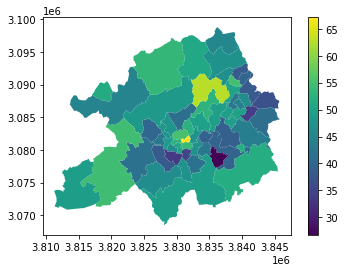

In [82]:
# 
gfa_gu_eub.plot(column='m2cap',legend=True)

Text(0, 0.5, 'Floorspace (m2/cap)')

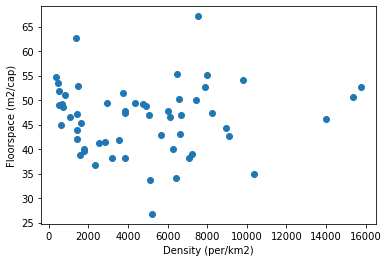

In [83]:
# we don't see an expected relationship between density and m2/cap
plt.scatter(gfa_gu_eub['Density'],gfa_gu_eub['m2cap'])
plt.xlabel("Density (per/km2)")
plt.ylabel("Floorspace (m2/cap)")

In [84]:
# don't find a neg corr between m2cap and density, not what we want/expect
gfa_gu_eub[['Density','m2cap']].corr()

,Density,m2cap
Density,1.00000,0.03355
m2cap,0.03355,1.00000


In [85]:
# geo-unit 101 has a higher median number of stories than most geounits
bldg_gu.groupby('geo_unit')['Stories'].median().head(15)

geo_unit
101    4.0
102    4.0
103    3.0
104    3.0
105    4.0
106    3.0
107    2.0
108    2.0
109    3.0
110    2.0
111    3.0
112    2.0
113    2.0
114    1.0
115    2.0
Name: Stories, dtype: float64

In [86]:
# much larger buildings on average in 101, 102, 105, 106
bldg_gu.groupby('geo_unit')['Floor_area'].describe().head(10)

,count,mean,std,min,25%,50%,75%,max
geo_unit,,,,,,,,
101,704.0,730.566879,1744.098576,27.367076,250.319288,399.727331,797.180459,36072.257360
102,1418.0,648.604960,1193.886451,17.142154,247.406859,350.145309,552.942304,22183.844507
103,3622.0,286.685322,514.765493,15.428149,115.677229,200.621045,296.418462,13696.849102
104,2797.0,338.883397,727.246561,15.652363,99.655113,176.751950,285.731301,11431.968946
105,1592.0,515.219293,792.673688,14.186922,203.874656,303.645998,482.980941,9583.555316
106,2227.0,474.280339,946.716664,16.005431,137.849104,233.295077,428.132925,12336.650687
107,3267.0,296.905065,814.400079,10.568716,102.570087,156.254120,233.648035,19098.058681
108,4547.0,180.149607,317.794890,13.025916,90.647559,131.913663,178.313584,6174.782882
109,2492.0,283.967516,688.162034,14.352108,90.018172,148.921881,234.730876,15956.422880


For now we scale up living area and energy and emissions by the ratio of GFA in the dpe sample to GFA in EUBUCCO

What do we do about the unknown vintages from eubucco? Distribute them across all vintages based on the shares vintage shares calculated with known vintages


In [87]:
dpe_gu['periode_construction_dpe'].unique()

array(['2006-2012', 'avant 1948', '1948-1974', '1989-2000', '1978-1982',
       '1975-1977', '1983-1988', '2001-2005', '2013-2021', 'après 2021'],
      dtype=object)

In [88]:
# match labelling with that from EUBUCCO
dpe_gu.loc[dpe_gu['periode_construction_dpe']=='avant 1948','periode_construction_dpe']='<1948'
dpe_gu.loc[dpe_gu['periode_construction_dpe']=='après 2021','periode_construction_dpe']='2022+'
dpe_gu['periode_construction_dpe'].unique()

array(['2006-2012', '<1948', '1948-1974', '1989-2000', '1978-1982',
       '1975-1977', '1983-1988', '2001-2005', '2013-2021', '2022+'],
      dtype=object)

In [89]:
dpe_sum_gu=pd.DataFrame(dpe_gu.groupby(['geo_unit','periode_construction_dpe'])['living_area','gross_floor_area','final_energy_kWh','emissions_kgCO2'].sum()).reset_index()
dpe_sum_gu.head()

C:\Users\peter\AppData\Local\Temp\ipykernel_11168\3915936377.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dpe_sum_gu=pd.DataFrame(dpe_gu.groupby(['geo_unit','periode_construction_dpe'])['living_area','gross_floor_area','final_energy_kWh','emissions_kgCO2'].sum()).reset_index()


,geo_unit,periode_construction_dpe,living_area,gross_floor_area,final_energy_kWh,emissions_kgCO2
0,101,1948-1974,2497.840001,2997.408002,575348.701350,118299.855400
1,101,1975-1977,107.490000,128.988000,17255.210000,3939.290000
2,101,1978-1982,206.109000,247.330801,24685.461646,1704.149135
3,101,1983-1988,220.020000,264.024000,15872.655464,1032.410200
4,101,1989-2000,1630.738997,1956.886797,194576.090261,27136.166219


Now we check how much of the GFA of each vintage is represented in each spatial unit

In [90]:
gfa_vint_gu_eub=pd.DataFrame(bldg_gu.groupby(['geo_unit','vintage'])['Floor_area'].sum()).reset_index()
gfa_vint_gu_eub

,geo_unit,vintage,Floor_area
0,101,1948-1974,43769.987225
1,101,1975-1977,6177.734003
2,101,1978-1982,30793.282216
3,101,1983-1988,4491.889997
4,101,1989-2000,31039.363510
...,...,...,...
565,157,2001-2005,36415.465474
566,157,2006-2012,106875.444907
567,157,2013-2021,14409.438584
568,157,<1948,348265.174611


In [91]:
gfa_vint_gu_eub=gfa_vint_gu_eub.merge(gfa_gu_eub.loc[:,['geo_unit','Floor_area']].rename(columns={'Floor_area':'Floor_area_total'}))
gfa_vint_gu_eub.head()

,geo_unit,vintage,Floor_area,Floor_area_total
0,101,1948-1974,43769.987225,514319.083121
1,101,1975-1977,6177.734003,514319.083121
2,101,1978-1982,30793.282216,514319.083121
3,101,1983-1988,4491.889997,514319.083121
4,101,1989-2000,31039.363510,514319.083121


In [92]:
gfa_vint_gu_eub_noNA=pd.DataFrame(bldg_gu.loc[bldg_gu['vintage']!='unknown',:].groupby(['geo_unit','vintage'])['Floor_area'].sum()).reset_index()
gfa_vint_gu_eub_noNA=gfa_vint_gu_eub_noNA.merge(pd.DataFrame(bldg_gu.loc[bldg_gu['vintage']!='unknown',:].groupby(['geo_unit'])['Floor_area'].sum()).reset_index().rename(columns={'Floor_area':'Partial_total'}))
gfa_vint_gu_eub_noNA['shares_noNA']=gfa_vint_gu_eub_noNA['Floor_area']/gfa_vint_gu_eub_noNA['Partial_total']
gfa_vint_gu_eub_noNA.head()

,geo_unit,vintage,Floor_area,Partial_total,shares_noNA
0,101,1948-1974,43769.987225,437309.300242,0.100089
1,101,1975-1977,6177.734003,437309.300242,0.014127
2,101,1978-1982,30793.282216,437309.300242,0.070415
3,101,1983-1988,4491.889997,437309.300242,0.010272
4,101,1989-2000,31039.363510,437309.300242,0.070978


In [93]:
# calculate estimated floor area by scaling the known vintage shares by the actual GFA totals
gfa_vint_gu_eub=gfa_vint_gu_eub.merge(gfa_vint_gu_eub_noNA,how='left')
gfa_vint_gu_eub['Floor_area_est']=gfa_vint_gu_eub['shares_noNA']*gfa_vint_gu_eub['Floor_area_total']
gfa_vint_gu_eub

,geo_unit,vintage,Floor_area,Floor_area_total,Partial_total,shares_noNA,Floor_area_est
0,101,1948-1974,43769.987225,5.143191e+05,437309.300242,0.100089,51477.843452
1,101,1975-1977,6177.734003,5.143191e+05,437309.300242,0.014127,7265.627524
2,101,1978-1982,30793.282216,5.143191e+05,437309.300242,0.070415,36215.952112
3,101,1983-1988,4491.889997,5.143191e+05,437309.300242,0.010272,5282.907872
4,101,1989-2000,31039.363510,5.143191e+05,437309.300242,0.070978,36505.368106
...,...,...,...,...,...,...,...
565,157,2001-2005,36415.465474,1.009905e+06,911052.738314,0.039971,40366.680696
566,157,2006-2012,106875.444907,1.009905e+06,911052.738314,0.117310,118471.833399
567,157,2013-2021,14409.438584,1.009905e+06,911052.738314,0.015816,15972.916966
568,157,<1948,348265.174611,1.009905e+06,911052.738314,0.382267,386053.258359


In [94]:
gfa_vint_gu_eub.drop(columns={'Floor_area_total','Partial_total','shares_noNA'},inplace=True)
dpe_sum_gu.rename(columns={'periode_construction_dpe':'vintage'},inplace=True)
gfa_vint_gu_eub

,geo_unit,vintage,Floor_area,Floor_area_est
0,101,1948-1974,43769.987225,51477.843452
1,101,1975-1977,6177.734003,7265.627524
2,101,1978-1982,30793.282216,36215.952112
3,101,1983-1988,4491.889997,5282.907872
4,101,1989-2000,31039.363510,36505.368106
...,...,...,...,...
565,157,2001-2005,36415.465474,40366.680696
566,157,2006-2012,106875.444907,118471.833399
567,157,2013-2021,14409.438584,15972.916966
568,157,<1948,348265.174611,386053.258359


### 6. Combine data to esimate residential energy/cap and emissions/cap in each spatial unit

#### Assumptions/decisions in this section: 
 - Assumption of vacancy rate

In [95]:
# summary of energy and emissions by building vintages in each geo_unit 
summary_dpe_eub=gfa_vint_gu_eub.merge(dpe_sum_gu,how='left')
# calculate the GFA ratio as the ratio between the EUBUCCO total floor area estimate and the DPE/BDND total floor area estimate
summary_dpe_eub['GFA_ratio']=summary_dpe_eub['Floor_area_est']/summary_dpe_eub['gross_floor_area']
# factor in a vacancy rate, as vacant buildings are represented implicitly in the EUBUCCO floor area estimates, but not in the DPE/BDND data
# when we are able to (with better data), we can consider variation in vacancies by location, building type, and age
# for now we assume a global vacancy rate of 5%
vacancy=0.05
summary_dpe_eub['GFA_ratio']=summary_dpe_eub['GFA_ratio']*(1-vacancy)
summary_dpe_eub

,geo_unit,vintage,Floor_area,Floor_area_est,living_area,gross_floor_area,final_energy_kWh,emissions_kgCO2,GFA_ratio
0,101,1948-1974,43769.987225,51477.843452,2497.840001,2997.408002,5.753487e+05,118299.855400,16.315414
1,101,1975-1977,6177.734003,7265.627524,107.490000,128.988000,1.725521e+04,3939.290000,53.511537
2,101,1978-1982,30793.282216,36215.952112,206.109000,247.330801,2.468546e+04,1704.149135,139.105823
3,101,1983-1988,4491.889997,5282.907872,220.020000,264.024000,1.587266e+04,1032.410200,19.008736
4,101,1989-2000,31039.363510,36505.368106,1630.738997,1956.886797,1.945761e+05,27136.166219,17.722078
...,...,...,...,...,...,...,...,...,...
565,157,2001-2005,36415.465474,40366.680696,1557.550000,1869.060000,1.581526e+05,24274.644600,20.517451
566,157,2006-2012,106875.444907,118471.833399,6654.457999,7985.349599,5.863258e+05,61910.749568,14.094341
567,157,2013-2021,14409.438584,15972.916966,727.050000,872.460000,6.322244e+04,9231.170000,17.392512
568,157,<1948,348265.174611,386053.258359,13688.457002,16426.148402,2.556281e+06,491622.292942,22.327242


In [96]:
# in 3 cases the dpe data actually exceed the eubucco data, pointing to potential underestimtations in some segments of EUBUCCO
summary_dpe_eub['GFA_ratio'].describe()

count    497.000000
mean      35.589912
std       37.113011
min        0.410937
25%       17.879719
50%       25.474868
75%       37.979135
max      332.988297
Name: GFA_ratio, dtype: float64

In [97]:
# scale up the estimates of emissions and energy per spatial unit, using the GFA ratio
summary_dpe_eub['final_energy_tot_GWh']=summary_dpe_eub['final_energy_kWh']*summary_dpe_eub['GFA_ratio']*1e-6
summary_dpe_eub['emissions_ktCO2']=summary_dpe_eub['emissions_kgCO2']*summary_dpe_eub['GFA_ratio']*1e-6
summary_dpe_eub

,geo_unit,vintage,Floor_area,Floor_area_est,living_area,gross_floor_area,final_energy_kWh,emissions_kgCO2,GFA_ratio,final_energy_tot_GWh,emissions_ktCO2
0,101,1948-1974,43769.987225,51477.843452,2497.840001,2997.408002,5.753487e+05,118299.855400,16.315414,9.387052,1.930111
1,101,1975-1977,6177.734003,7265.627524,107.490000,128.988000,1.725521e+04,3939.290000,53.511537,0.923353,0.210797
2,101,1978-1982,30793.282216,36215.952112,206.109000,247.330801,2.468546e+04,1704.149135,139.105823,3.433891,0.237057
3,101,1983-1988,4491.889997,5282.907872,220.020000,264.024000,1.587266e+04,1032.410200,19.008736,0.301719,0.019625
4,101,1989-2000,31039.363510,36505.368106,1630.738997,1956.886797,1.945761e+05,27136.166219,17.722078,3.448293,0.480909
...,...,...,...,...,...,...,...,...,...,...,...
565,157,2001-2005,36415.465474,40366.680696,1557.550000,1869.060000,1.581526e+05,24274.644600,20.517451,3.244888,0.498054
566,157,2006-2012,106875.444907,118471.833399,6654.457999,7985.349599,5.863258e+05,61910.749568,14.094341,8.263876,0.872591
567,157,2013-2021,14409.438584,15972.916966,727.050000,872.460000,6.322244e+04,9231.170000,17.392512,1.099597,0.160553
568,157,<1948,348265.174611,386053.258359,13688.457002,16426.148402,2.556281e+06,491622.292942,22.327242,57.074712,10.976570


In [98]:
# summar over vintages to get total energy and emissions per spatial unit
eetot_gu=summary_dpe_eub.groupby('geo_unit')['final_energy_tot_GWh','emissions_ktCO2'].sum().reset_index()

C:\Users\peter\AppData\Local\Temp\ipykernel_11168\4097074377.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  eetot_gu=summary_dpe_eub.groupby('geo_unit')['final_energy_tot_GWh','emissions_ktCO2'].sum().reset_index()


In [99]:
# summary of population, floor area, m2/cap, energy and emissions absolute and per cap per each spatial unit
summary=gfa_gu_eub.merge(eetot_gu)
summary['FE_MWhcap']=1e3*summary['final_energy_tot_GWh']/summary['Population']
summary['GHG_tcap']=1e3*summary['emissions_ktCO2']/summary['Population']
summary.head(10)

,geo_unit,geometry,area,Population,Density,Floor_area,m2cap,final_energy_tot_GWh,emissions_ktCO2,FE_MWhcap,GHG_tcap
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,5.143191e+05,67.117197,74.142154,12.813137,9.675343,1.672078
1,102,"POLYGON ((3830948.302 3080000.986, 3830842.526...",1.736899,17020.0,9799.0,9.197218e+05,54.037711,119.494746,20.028336,7.020843,1.176753
2,103,"POLYGON ((3830813.962 3079445.052, 3830830.781...",1.332421,20474.0,15366.0,1.038374e+06,50.716725,126.927767,18.440615,6.199461,0.900685
3,104,"POLYGON ((3830131.702 3080002.606, 3830140.054...",1.467545,20511.0,13976.0,9.478569e+05,46.212123,137.135312,24.593240,6.685940,1.199027
4,105,"POLYGON ((3829671.427 3080837.090, 3829662.212...",0.989090,15571.0,15743.0,8.202291e+05,52.676714,108.501538,16.970115,6.968180,1.089854
5,106,"POLYGON ((3831810.688 3082274.034, 3831803.157...",2.957367,19086.0,6454.0,1.056222e+06,55.340161,112.761541,14.977324,5.908076,0.784728
6,107,"POLYGON ((3833501.848 3082846.705, 3833549.183...",2.479507,20460.0,8252.0,9.699888e+05,47.409034,126.821596,23.125101,6.198514,1.130259
7,108,"POLYGON ((3831926.590 3079251.636, 3831955.356...",2.620403,17440.0,6655.0,8.191403e+05,46.969052,108.986861,19.623400,6.249247,1.125195
8,109,"POLYGON ((3832053.301 3079193.884, 3832120.196...",1.948714,20223.0,10378.0,7.076471e+05,34.992190,91.142804,15.687550,4.506888,0.775728
9,110,"POLYGON ((3830262.285 3079466.981, 3830315.640...",3.840035,19726.0,5137.0,6.652050e+05,33.722245,105.003098,20.143767,5.323081,1.021178


In [100]:
# French total emissions are 5-6 t/cap, and residential is about 20% of total, so residential GHG should be about 1 t/cap, or slightly higher, which is consistent with what we see here. https://www.planete-energies.com/en/media/article/greenhouse-gas-emissions-france
# Nord is in the north of france, with higher heating requirements, so it would be natural to see estimates here which are above national average. 
# However, in an urban region such as we have here, we would probably expect lower m2/cap than national average (once we have our data right), and thus lower emissions
summary['GHG_tcap'].describe()

count    57.000000
mean      1.164334
std       0.204425
min       0.646277
25%       1.037731
50%       1.135932
75%       1.270238
max       1.672078
Name: GHG_tcap, dtype: float64

<AxesSubplot:>

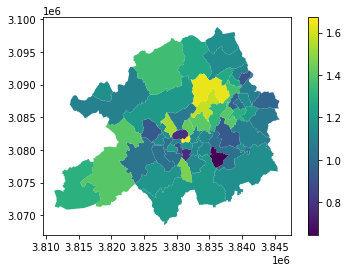

In [101]:
# emission/cap throuhout Lille
summary.plot(column='GHG_tcap',legend=True)

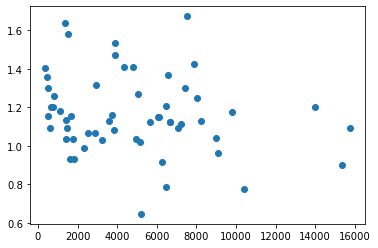

In [102]:
# emissions vs density
plt.scatter(summary['Density'],summary['GHG_tcap'])

In [103]:
# a slight negative correlation of density and emissions per capita
summary[['Density','GHG_tcap']].corr()

,Density,GHG_tcap
Density,1.000000,-0.200237
GHG_tcap,-0.200237,1.000000
